about Fashion-MNIST: https://www.tensorflow.org/datasets/catalog/fashion_mnist (black and white images of clothing)

about CIFAR10: https://www.tensorflow.org/datasets/catalog/cifar10 (images of cats! These images include colour and cannot be flatten using code from labs 2 or 3.)





In [ ]:
pip install optuna

     -------------------------------------- 348.3/348.3 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 81.0/81.0 kB 4.4 MB/s eta 0:00:00
     -------------------------------------- 209.8/209.8 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 101.6/101.6 kB 1.9 MB/s eta 0:00:00
     -------------------------------------- 147.1/147.1 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 49.5/49.5 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 112.4/112.4 kB 6.8 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11106 sha256=a3a4e9efc

In [ ]:
##importing packages
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import optuna

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation,Conv2D,MaxPooling2D,Dropout,Flatten
from keras.optimizers import *
#from tf.keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
##utility functions
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))


In [1]:
##mounting google drive for storage
from google.colab import drive
drive.mount('/content/gdrive')

NameError: ignored

In [2]:
# import and load data
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# cats data set
#from keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# display info about data & assign image size
print("Training data shape: ", x_train.shape) 
print("Test data shape", x_test.shape)
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)
image_size = (x_train.shape[1], x_train.shape[2])

# flatten the images
image_vector_size = image_size[0] * image_size[1] #28 * 28 for fashion

##input for a convolutional network
conv_x_train = x_train.reshape(x_train.shape + (1,) ) /255. ##add colour channel and scale
conv_x_test = x_test.reshape(x_test.shape + (1,) ) /255. 
print(conv_x_train.shape)

##input for artificial neural network 
ann_x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255. 
ann_x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255. 
print(ann_x_train.shape)

# convert to "one-hot" vectors using the to_categorical function

num_classes = 10 #number of output classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

4422102/4422102 [==============================] - 0s 0us/step
Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)
(60000, 28, 28, 1)
(60000, 784)


NameError: ignored

In [3]:
import copy as c

def build_NN(n_initial_units,n_hidden_units,n_hidden_layers,dropout_rate=0,network_type='ANN'):
  ####code to generate either an Aritificial Neural Network or a Convolutional Neural Network given selected inputs
  global x_train,x_test #allows overwriring of these global variables
  if network_type == "ANN":
    activation = 'sigmoid'
    x_train = c.deepcopy(ann_x_train)
    x_test = c.deepcopy(ann_x_test)
    print(x_train.shape)
    model = Sequential()
    # The input layer requires the special input_shape parameter which should match the shape of our training data.
    model.add(Dense(units=n_initial_units, activation=activation, input_shape=(image_vector_size,)))
    model.add(Dropout(dropout_rate))

    ##"hidden" layers in the architecture
    if n_hidden_layers > 0:
      for i in range(n_hidden_layers):
        model.add(Dense(units=n_hidden_units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=num_classes, activation='softmax'))

  elif network_type == "CNN":
    activation = 'relu'
    ##setting new x_train and y_train 
    x_train = c.deepcopy(conv_x_train)
    x_test = c.deepcopy(conv_x_test)
    model = Sequential()

  
    # The input layer requires the special input_shape parameter which should match the shape of our training data.
    model.add(Conv2D(n_initial_units, (3, 3), activation=activation, input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))

    ##"hidden" layers in the architecture
    if n_hidden_layers > 0:
      for i in range(n_hidden_layers):
        n_hidden_units = n_hidden_units / 2 ##halfing the size of each layer 
        model.add(Conv2D(n_hidden_units, (3, 3), activation=activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(dropout_rate))

    ##final dense layer(s)
    model.add(Flatten())
    #model.add(Dense(n_hidden_units, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))

  return model

In [4]:

def obtain_random_architecture_params():
  new_arr = []
  for (key,vals) in arch_dict.items():
    new_arr.append(random.choice(vals))
  return  tuple(new_arr)

In [6]:
def objective(trial):
    model = build_NN(n_initial_units,n_hidden_units,n_hidden_layers,dropout_rate=dropout_rate,network_type=arch_type)  ##obtain random architecture 
    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True) #sample values of learning rate between 1e-5 and 1e-1
    #loss = trial.suggest_categorical('loss',['categorical_crossentropy']) ##if we  want to vary the loss function
    optimizer = trial.suggest_categorical('optimizer',['sgd','adam','adadelta','nadam'])
    batch_size = trial.suggest_categorical('batch_size',[2,4,8,16,32,64,128])
    ##code to vary the optimizer.
    if optimizer == 'sgd':
      optimizer = tf.keras.optimizers.SGD
    elif optimizer == 'adam':
      optimizer = tf.keras.optimizers.Adam
    elif optimizer == 'adadelta':
      optimizer = tf.keras.optimizers.Adadelta
    elif optimizer == 'nadam':
      optimizer = tf.keras.optimizers.Nadam

    model.compile(optimizer(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]
    return acc,loss 

In [7]:
##function to run a particular study
def run_study(study_name=None,n_trials=20):
  """creates an optuna study and optimises the objective function"""
  study = optuna.create_study(directions=['maximize','minimize'],study_name=study_name) # we would like to maximise the validation accuracy
  study.optimize(objective, n_trials=n_trials)
  return study

In [8]:

def run_studies(n_architectures,n_trials,arch_type,n_epochs):

  for i in range(n_architectures): ##creating a study for each architecture
    print(f"Testing for architecture #{i+1}")
    global n_initial_units,n_hidden_units,n_hidden_layers,dropout_rate
    n_initial_units,n_hidden_units,n_hidden_layers,dropout_rate = obtain_random_architecture_params()   #obtain random architecture parameters
    
    study_name = "#" + str(i+1) + f"\n{arch_type} Architecture\n_initial_units: {n_initial_units},n_hidden_units: {n_hidden_units},n_hidden_layers: {n_hidden_layers},dropout_rate: {dropout_rate}"     ##defining a study name to be stored
    study = run_study(study_name,n_trials)
    studies.append(study) ##storing each study in list of studies
  return None
  

In [9]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

ModuleNotFoundError: ignored

In [10]:
##best parameters for each study
def results_as_df():
  studies_dicts = []

  for selected_study in studies:
    print("="*40)
    print()
    print(f"Architecture: {selected_study.study_name}")
    print("Number of finished trials: {}\n".format(len(selected_study.trials)))
    #print("Best trials for Study:")
    best_trials = selected_study.best_trials
    
    for best_trial in best_trials:
      print("Results\n")
      print(f"Accuracy: {best_trial.values[0]}")
      print(f"Loss: {best_trial.values[1]}")
      print("Parameters\n")
      for (key,val) in best_trial.params.items():
        print(key,": ",val)

      keys = list(best_trial.params.keys()) 
      values = list(best_trial.params.values())

      studies_dicts.append({"Study Name":selected_study.study_name,
                            "Accuracy":float(best_trial.values[0]),
                            "Loss":float(best_trial.values[1]),
                            keys[0]:float(values[0]),
                            keys[1]:str(values[1]),
                            keys[2]:float(values[2])})
                            
                                                    
    print()

  studies_dicts
  ##storing in dataframe 
  pd.set_option('display.precision', 4)
  pd.set_option('max_colwidth', 200)
  df = pd.DataFrame()

  print("Best Results for each study")

  for idx,study in enumerate(studies_dicts):
    df1 = pd.DataFrame.from_dict(study,orient='index')
    df1.columns = [f"Best Trial#{idx+1}"]
    df = pd.concat([df,df1],axis=1)

  return df  

In [11]:
##dictionary of target indices
def output_plots(name="ANN"):
  ##saving visualisations to Google drive for later reference
  for study_number in range(len(studies)):
      for target_name in ["accuracy","loss"]:

        p1_str = f"/{name} Study#{study_number + 1}_Optimization_History_for_{target_name}.png"
        p2_str = f"/{name} Study#{study_number + 1}_Contour_Plot_for_{target_name}.png"
        p3_str = f"/{name} Study#{study_number +1 }_Parameter_Importances_for_{target_name}.png"

        p1 = optuna.visualization.matplotlib.plot_optimization_history(studies[study_number],target=lambda t: t.values[target_dict[target_name]],target_name=target_name)
        plt.savefig(drive_path+p1_str)
        plt.show()

        p2 = optuna.visualization.matplotlib.plot_contour(studies[study_number],target=lambda t: t.values[target_dict[target_name]],target_name=target_name,params=["lr", "optimizer","batch_size"])
        plt.savefig(drive_path+p2_str)
        plt.show()
        
        p3 = optuna.visualization.matplotlib.plot_param_importances(studies[study_number],target=lambda t: t.values[target_dict[target_name]],target_name=target_name,params=["lr", "optimizer","batch_size"])
        plt.savefig(drive_path+p3_str)
        plt.show()

      p4 = optuna.visualization.matplotlib.plot_pareto_front(studies[study_number],target_names=["accuracy","loss"])
      p4_str = f"/{name} Study#{study_number + 1}_Pareto_Front.png"
      plt.savefig(drive_path+p4_str)
      plt.show()


In [12]:


##generating random architectures and storing results
import random

initial_units = [8,16,32,64]
n_hidden_units = [8,16,32,64]
n_hidden_layers = [0,1,2]
dropout_rates = [0,0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5]

arch_dict = {"n_initial_units":initial_units,
             "n_hidden_units":n_hidden_units,
             "n_hidden_layers":n_hidden_layers,
             "dropout_rate":dropout_rates
             }


In [13]:

#drive_path = '/content/gdrive/My Drive/BigDataResults/' ##to save to drive
#drive_path = 'C:/Users/xande/OneDrive - University of Canterbury/Semester2MADS/Big_Data/Assignments/Assignment 3/NNResults/'
#writing dataframe results to csv
##initializing target indexes used for plots
target_dict = {
    "accuracy":0,
    "loss":1
}

global arch_type
##run studies for ANNs



In [ ]:
n_architectures,n_trials,n_epochs,arch_type = 6,15,25,'ANN' ##Defining function parameters

studies = [] ##initialise studies
run_studies(n_architectures,n_trials,arch_type,n_epochs)
df = results_as_df()
#saving dataframe to Google drive for later reference
df.to_csv(drive_path+"/ANN_Best_results.csv")
##storing outputs as plots in google drive
output_plots(name=arch_type)


[I 2022-10-11 22:51:03,106] A new study created in memory with name: #1
CNN Architecture
_initial_units: 64,n_hidden_units: 32,n_hidden_layers: 1,dropout_rate: 0.3


Testing for architecture #1
Epoch 1/25
13500/13500 [==============================] - 112s 8ms/step - loss: 0.5348 - accuracy: 0.8059 - val_loss: 0.3744 - val_accuracy: 0.8625
Epoch 2/25
13500/13500 [==============================] - 101s 7ms/step - loss: 0.4116 - accuracy: 0.8506 - val_loss: 0.3541 - val_accuracy: 0.8697
Epoch 3/25
13500/13500 [==============================] - 107s 8ms/step - loss: 0.3903 - accuracy: 0.8572 - val_loss: 0.3334 - val_accuracy: 0.8755
Epoch 4/25
13500/13500 [==============================] - 97s 7ms/step - loss: 0.3785 - accuracy: 0.8629 - val_loss: 0.3365 - val_accuracy: 0.8770
Epoch 5/25
13500/13500 [==============================] - 97s 7ms/step - loss: 0.3728 - accuracy: 0.8640 - val_loss: 0.3319 - val_accuracy: 0.8797
Epoch 6/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.3668 - accuracy: 0.8674 - val_loss: 0.3170 - val_accuracy: 0.8858
Epoch 7/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.3639 -

[I 2022-10-11 23:32:13,814] Trial 0 finished with values: [0.8886666893959045, 0.3003886938095093] and parameters: {'lr': 0.001070658494734655, 'optimizer': 'nadam', 'batch_size': 4}. 


Epoch 1/25
844/844 [==============================] - 65s 75ms/step - loss: 1.0508 - accuracy: 0.6193 - val_loss: 0.6167 - val_accuracy: 0.7725
Epoch 2/25
844/844 [==============================] - 64s 76ms/step - loss: 0.6463 - accuracy: 0.7607 - val_loss: 0.5286 - val_accuracy: 0.8058
Epoch 3/25
844/844 [==============================] - 64s 76ms/step - loss: 0.5672 - accuracy: 0.7907 - val_loss: 0.4803 - val_accuracy: 0.8277
Epoch 4/25
844/844 [==============================] - 62s 73ms/step - loss: 0.5207 - accuracy: 0.8091 - val_loss: 0.4444 - val_accuracy: 0.8453
Epoch 5/25
844/844 [==============================] - 62s 74ms/step - loss: 0.4888 - accuracy: 0.8239 - val_loss: 0.4273 - val_accuracy: 0.8503
Epoch 6/25
844/844 [==============================] - 62s 73ms/step - loss: 0.4697 - accuracy: 0.8299 - val_loss: 0.4099 - val_accuracy: 0.8552
Epoch 7/25
844/844 [==============================] - 63s 75ms/step - loss: 0.4487 - accuracy: 0.8387 - val_loss: 0.3997 - val_accuracy:

[I 2022-10-11 23:58:32,083] Trial 1 finished with values: [0.8913333415985107, 0.3060993552207947] and parameters: {'lr': 0.00025965306734908544, 'optimizer': 'nadam', 'batch_size': 64}. 


Epoch 1/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.3266 - accuracy: 0.0978 - val_loss: 2.3051 - val_accuracy: 0.0963
Epoch 2/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.3109 - accuracy: 0.1046 - val_loss: 2.2942 - val_accuracy: 0.0950
Epoch 3/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2975 - accuracy: 0.1082 - val_loss: 2.2845 - val_accuracy: 0.0925
Epoch 4/25
6750/6750 [==============================] - 81s 12ms/step - loss: 2.2862 - accuracy: 0.1113 - val_loss: 2.2756 - val_accuracy: 0.0917
Epoch 5/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2757 - accuracy: 0.1166 - val_loss: 2.2672 - val_accuracy: 0.0895
Epoch 6/25
6750/6750 [==============================] - 81s 12ms/step - loss: 2.2654 - accuracy: 0.1188 - val_loss: 2.2591 - val_accuracy: 0.0892
Epoch 7/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2555 - accuracy: 0.1256 - val_loss: 2.2511 -

[I 2022-10-12 00:33:04,218] Trial 2 finished with values: [0.39883333444595337, 1.9892514944076538] and parameters: {'lr': 0.00022566806870961135, 'optimizer': 'adadelta', 'batch_size': 8}. 


Epoch 1/25
1688/1688 [==============================] - 73s 43ms/step - loss: 0.6834 - accuracy: 0.7517 - val_loss: 0.4442 - val_accuracy: 0.8442
Epoch 2/25
1688/1688 [==============================] - 66s 39ms/step - loss: 0.4616 - accuracy: 0.8317 - val_loss: 0.3812 - val_accuracy: 0.8627
Epoch 3/25
1688/1688 [==============================] - 67s 40ms/step - loss: 0.4163 - accuracy: 0.8488 - val_loss: 0.3505 - val_accuracy: 0.8742
Epoch 4/25
1688/1688 [==============================] - 66s 39ms/step - loss: 0.3877 - accuracy: 0.8603 - val_loss: 0.3341 - val_accuracy: 0.8787
Epoch 5/25
1688/1688 [==============================] - 70s 41ms/step - loss: 0.3705 - accuracy: 0.8661 - val_loss: 0.3276 - val_accuracy: 0.8820
Epoch 6/25
1688/1688 [==============================] - 68s 40ms/step - loss: 0.3589 - accuracy: 0.8697 - val_loss: 0.3016 - val_accuracy: 0.8908
Epoch 7/25
1688/1688 [==============================] - 70s 42ms/step - loss: 0.3482 - accuracy: 0.8740 - val_loss: 0.3027 -

[I 2022-10-12 01:01:22,601] Trial 3 finished with values: [0.8999999761581421, 0.27451929450035095] and parameters: {'lr': 0.0008238171701412616, 'optimizer': 'nadam', 'batch_size': 32}. 


Epoch 1/25
422/422 [==============================] - 64s 150ms/step - loss: 1.9690 - accuracy: 0.3056 - val_loss: 1.2497 - val_accuracy: 0.6307
Epoch 2/25
422/422 [==============================] - 62s 146ms/step - loss: 1.1368 - accuracy: 0.5839 - val_loss: 0.8382 - val_accuracy: 0.7202
Epoch 3/25
422/422 [==============================] - 56s 133ms/step - loss: 0.9001 - accuracy: 0.6716 - val_loss: 0.7345 - val_accuracy: 0.7403
Epoch 4/25
422/422 [==============================] - 56s 133ms/step - loss: 0.8092 - accuracy: 0.7047 - val_loss: 0.6821 - val_accuracy: 0.7607
Epoch 5/25
422/422 [==============================] - 56s 132ms/step - loss: 0.7505 - accuracy: 0.7247 - val_loss: 0.6442 - val_accuracy: 0.7652
Epoch 6/25
422/422 [==============================] - 64s 153ms/step - loss: 0.7175 - accuracy: 0.7374 - val_loss: 0.6172 - val_accuracy: 0.7773
Epoch 7/25
422/422 [==============================] - 56s 133ms/step - loss: 0.6876 - accuracy: 0.7501 - val_loss: 0.5978 - val_ac

[I 2022-10-12 01:25:09,604] Trial 4 finished with values: [0.8360000252723694, 0.4631614089012146] and parameters: {'lr': 0.007854187241385356, 'optimizer': 'sgd', 'batch_size': 128}. 


Epoch 1/25
6750/6750 [==============================] - 88s 13ms/step - loss: 1.0346 - accuracy: 0.6286 - val_loss: 0.6284 - val_accuracy: 0.7672
Epoch 2/25
6750/6750 [==============================] - 86s 13ms/step - loss: 0.6510 - accuracy: 0.7578 - val_loss: 0.5251 - val_accuracy: 0.8047
Epoch 3/25
6750/6750 [==============================] - 85s 13ms/step - loss: 0.5629 - accuracy: 0.7912 - val_loss: 0.4694 - val_accuracy: 0.8313
Epoch 4/25
6750/6750 [==============================] - 86s 13ms/step - loss: 0.5144 - accuracy: 0.8124 - val_loss: 0.4364 - val_accuracy: 0.8455
Epoch 5/25
6750/6750 [==============================] - 84s 12ms/step - loss: 0.4809 - accuracy: 0.8251 - val_loss: 0.4142 - val_accuracy: 0.8488
Epoch 6/25
6750/6750 [==============================] - 85s 13ms/step - loss: 0.4603 - accuracy: 0.8337 - val_loss: 0.4000 - val_accuracy: 0.8593
Epoch 7/25
6750/6750 [==============================] - 85s 13ms/step - loss: 0.4421 - accuracy: 0.8413 - val_loss: 0.3850 -

[I 2022-10-12 02:00:30,945] Trial 5 finished with values: [0.8893333077430725, 0.3050096929073334] and parameters: {'lr': 8.097235729482496e-05, 'optimizer': 'nadam', 'batch_size': 8}. 


Epoch 1/25
6750/6750 [==============================] - 83s 12ms/step - loss: 2.3163 - accuracy: 0.0951 - val_loss: 2.2991 - val_accuracy: 0.1497
Epoch 2/25
6750/6750 [==============================] - 84s 12ms/step - loss: 2.3072 - accuracy: 0.1098 - val_loss: 2.2924 - val_accuracy: 0.1833
Epoch 3/25
6750/6750 [==============================] - 83s 12ms/step - loss: 2.2981 - accuracy: 0.1273 - val_loss: 2.2862 - val_accuracy: 0.2082
Epoch 4/25
6750/6750 [==============================] - 81s 12ms/step - loss: 2.2904 - accuracy: 0.1433 - val_loss: 2.2802 - val_accuracy: 0.2257
Epoch 5/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2836 - accuracy: 0.1570 - val_loss: 2.2745 - val_accuracy: 0.2422
Epoch 6/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2768 - accuracy: 0.1719 - val_loss: 2.2691 - val_accuracy: 0.2528
Epoch 7/25
6750/6750 [==============================] - 82s 12ms/step - loss: 2.2693 - accuracy: 0.1817 - val_loss: 2.2635 -

[I 2022-10-12 02:35:14,501] Trial 6 finished with values: [0.42149999737739563, 2.046004295349121] and parameters: {'lr': 0.00021460743975259075, 'optimizer': 'adadelta', 'batch_size': 8}. 


Epoch 1/25
422/422 [==============================] - 63s 137ms/step - loss: 1.0550 - accuracy: 0.6268 - val_loss: 0.6056 - val_accuracy: 0.7777
Epoch 2/25
422/422 [==============================] - 57s 134ms/step - loss: 0.6350 - accuracy: 0.7660 - val_loss: 0.5076 - val_accuracy: 0.8190
Epoch 3/25
422/422 [==============================] - 56s 133ms/step - loss: 0.5465 - accuracy: 0.8007 - val_loss: 0.4595 - val_accuracy: 0.8363
Epoch 4/25
422/422 [==============================] - 58s 137ms/step - loss: 0.5023 - accuracy: 0.8193 - val_loss: 0.4204 - val_accuracy: 0.8513
Epoch 5/25
422/422 [==============================] - 57s 136ms/step - loss: 0.4693 - accuracy: 0.8325 - val_loss: 0.4067 - val_accuracy: 0.8565
Epoch 6/25
422/422 [==============================] - 59s 140ms/step - loss: 0.4508 - accuracy: 0.8386 - val_loss: 0.3862 - val_accuracy: 0.8630
Epoch 7/25
422/422 [==============================] - 58s 137ms/step - loss: 0.4347 - accuracy: 0.8440 - val_loss: 0.3822 - val_ac

[I 2022-10-12 02:59:18,399] Trial 7 finished with values: [0.893666684627533, 0.29915305972099304] and parameters: {'lr': 0.0004217553513688393, 'optimizer': 'adam', 'batch_size': 128}. 


Epoch 1/25
844/844 [==============================] - 63s 74ms/step - loss: 1.1560 - accuracy: 0.5801 - val_loss: 0.6790 - val_accuracy: 0.7628
Epoch 2/25
844/844 [==============================] - 62s 73ms/step - loss: 0.6932 - accuracy: 0.7430 - val_loss: 0.5602 - val_accuracy: 0.7943
Epoch 3/25
844/844 [==============================] - 63s 75ms/step - loss: 0.6156 - accuracy: 0.7727 - val_loss: 0.5207 - val_accuracy: 0.8168
Epoch 4/25
844/844 [==============================] - 62s 74ms/step - loss: 0.5757 - accuracy: 0.7877 - val_loss: 0.5041 - val_accuracy: 0.8183
Epoch 5/25
844/844 [==============================] - 63s 75ms/step - loss: 0.5517 - accuracy: 0.7950 - val_loss: 0.4876 - val_accuracy: 0.8243
Epoch 6/25
844/844 [==============================] - 63s 74ms/step - loss: 0.5320 - accuracy: 0.8044 - val_loss: 0.4678 - val_accuracy: 0.8270
Epoch 7/25
844/844 [==============================] - 61s 72ms/step - loss: 0.5148 - accuracy: 0.8106 - val_loss: 0.4557 - val_accuracy:

[I 2022-10-12 03:25:29,315] Trial 8 finished with values: [0.8763333559036255, 0.34567853808403015] and parameters: {'lr': 0.020435462759748453, 'optimizer': 'sgd', 'batch_size': 64}. 


Epoch 1/25
27000/27000 [==============================] - 127s 5ms/step - loss: 0.8068 - accuracy: 0.7069 - val_loss: 0.5346 - val_accuracy: 0.7975
Epoch 2/25
27000/27000 [==============================] - 126s 5ms/step - loss: 0.5479 - accuracy: 0.7979 - val_loss: 0.4629 - val_accuracy: 0.8357
Epoch 3/25
27000/27000 [==============================] - 127s 5ms/step - loss: 0.4919 - accuracy: 0.8199 - val_loss: 0.4220 - val_accuracy: 0.8403
Epoch 4/25
27000/27000 [==============================] - 127s 5ms/step - loss: 0.4582 - accuracy: 0.8341 - val_loss: 0.3869 - val_accuracy: 0.8613
Epoch 5/25
27000/27000 [==============================] - 126s 5ms/step - loss: 0.4374 - accuracy: 0.8400 - val_loss: 0.3857 - val_accuracy: 0.8613
Epoch 6/25
27000/27000 [==============================] - 125s 5ms/step - loss: 0.4189 - accuracy: 0.8477 - val_loss: 0.3656 - val_accuracy: 0.8663
Epoch 7/25
27000/27000 [==============================] - 124s 5ms/step - loss: 0.4053 - accuracy: 0.8547 - val_

[I 2022-10-12 04:18:04,555] Trial 9 finished with values: [0.8931666612625122, 0.29325059056282043] and parameters: {'lr': 0.00231978334218221, 'optimizer': 'sgd', 'batch_size': 2}. 


Epoch 1/25
3375/3375 [==============================] - 76s 22ms/step - loss: 1.1060 - accuracy: 0.6001 - val_loss: 0.6924 - val_accuracy: 0.7515
Epoch 2/25
3375/3375 [==============================] - 73s 22ms/step - loss: 0.7250 - accuracy: 0.7347 - val_loss: 0.5916 - val_accuracy: 0.7772
Epoch 3/25
3375/3375 [==============================] - 74s 22ms/step - loss: 0.6395 - accuracy: 0.7635 - val_loss: 0.5424 - val_accuracy: 0.7957
Epoch 4/25
3375/3375 [==============================] - 71s 21ms/step - loss: 0.5905 - accuracy: 0.7807 - val_loss: 0.5076 - val_accuracy: 0.8103
Epoch 5/25
3375/3375 [==============================] - 72s 21ms/step - loss: 0.5598 - accuracy: 0.7937 - val_loss: 0.4801 - val_accuracy: 0.8212
Epoch 6/25
3375/3375 [==============================] - 71s 21ms/step - loss: 0.5324 - accuracy: 0.8051 - val_loss: 0.4624 - val_accuracy: 0.8300
Epoch 7/25
3375/3375 [==============================] - 72s 21ms/step - loss: 0.5100 - accuracy: 0.8140 - val_loss: 0.4463 -

[I 2022-10-12 04:48:19,037] Trial 10 finished with values: [0.8694999814033508, 0.3556143045425415] and parameters: {'lr': 0.07644158589345092, 'optimizer': 'adadelta', 'batch_size': 16}. 


Epoch 1/25
27000/27000 [==============================] - 129s 5ms/step - loss: 2.3027 - accuracy: 0.1108 - val_loss: 2.2820 - val_accuracy: 0.1223
Epoch 2/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2860 - accuracy: 0.1234 - val_loss: 2.2737 - val_accuracy: 0.1235
Epoch 3/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2737 - accuracy: 0.1349 - val_loss: 2.2654 - val_accuracy: 0.1260
Epoch 4/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2613 - accuracy: 0.1460 - val_loss: 2.2565 - val_accuracy: 0.1355
Epoch 5/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2499 - accuracy: 0.1533 - val_loss: 2.2466 - val_accuracy: 0.1480
Epoch 6/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2378 - accuracy: 0.1661 - val_loss: 2.2355 - val_accuracy: 0.1618
Epoch 7/25
27000/27000 [==============================] - 128s 5ms/step - loss: 2.2252 - accuracy: 0.1747 - val_

[I 2022-10-12 05:42:01,885] Trial 11 finished with values: [0.4676666557788849, 1.736263632774353] and parameters: {'lr': 0.0001740171549498336, 'optimizer': 'adadelta', 'batch_size': 2}. 


Epoch 1/25
1688/1688 [==============================] - 71s 42ms/step - loss: 1.5035 - accuracy: 0.4482 - val_loss: 0.9212 - val_accuracy: 0.7005
Epoch 2/25
1688/1688 [==============================] - 70s 41ms/step - loss: 0.9503 - accuracy: 0.6512 - val_loss: 0.7552 - val_accuracy: 0.7325
Epoch 3/25
1688/1688 [==============================] - 67s 40ms/step - loss: 0.8193 - accuracy: 0.6995 - val_loss: 0.6759 - val_accuracy: 0.7522
Epoch 4/25
1688/1688 [==============================] - 67s 40ms/step - loss: 0.7426 - accuracy: 0.7266 - val_loss: 0.6318 - val_accuracy: 0.7683
Epoch 5/25
1688/1688 [==============================] - 72s 43ms/step - loss: 0.6953 - accuracy: 0.7431 - val_loss: 0.5949 - val_accuracy: 0.7758
Epoch 6/25
1688/1688 [==============================] - 70s 41ms/step - loss: 0.6610 - accuracy: 0.7536 - val_loss: 0.5688 - val_accuracy: 0.7855
Epoch 7/25
1688/1688 [==============================] - 69s 41ms/step - loss: 0.6335 - accuracy: 0.7654 - val_loss: 0.5518 -

[I 2022-10-12 06:10:39,093] Trial 12 finished with values: [0.8538333177566528, 0.4066319167613983] and parameters: {'lr': 0.046572240953440626, 'optimizer': 'adadelta', 'batch_size': 32}. 


Epoch 1/25
13500/13500 [==============================] - 102s 7ms/step - loss: 2.1661 - accuracy: 0.2199 - val_loss: 1.7934 - val_accuracy: 0.5540
Epoch 2/25
13500/13500 [==============================] - 97s 7ms/step - loss: 1.4515 - accuracy: 0.4806 - val_loss: 1.0373 - val_accuracy: 0.6788
Epoch 3/25
13500/13500 [==============================] - 99s 7ms/step - loss: 1.0975 - accuracy: 0.6003 - val_loss: 0.8792 - val_accuracy: 0.7028
Epoch 4/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.9739 - accuracy: 0.6400 - val_loss: 0.8117 - val_accuracy: 0.7233
Epoch 5/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.8987 - accuracy: 0.6685 - val_loss: 0.7627 - val_accuracy: 0.7273
Epoch 6/25
13500/13500 [==============================] - 99s 7ms/step - loss: 0.8473 - accuracy: 0.6876 - val_loss: 0.7278 - val_accuracy: 0.7357
Epoch 7/25
13500/13500 [==============================] - 97s 7ms/step - loss: 0.8061 - accuracy: 0.7034 - val_loss: 

[I 2022-10-12 06:51:42,691] Trial 13 finished with values: [0.809499979019165, 0.5202369689941406] and parameters: {'lr': 0.00016164954236113995, 'optimizer': 'sgd', 'batch_size': 4}. 


Epoch 1/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.6248 - accuracy: 0.7726 - val_loss: 0.4491 - val_accuracy: 0.8300
Epoch 2/25
13500/13500 [==============================] - 97s 7ms/step - loss: 0.4775 - accuracy: 0.8276 - val_loss: 0.3844 - val_accuracy: 0.8608
Epoch 3/25
13500/13500 [==============================] - 99s 7ms/step - loss: 0.4502 - accuracy: 0.8352 - val_loss: 0.3886 - val_accuracy: 0.8585
Epoch 4/25
13500/13500 [==============================] - 96s 7ms/step - loss: 0.4308 - accuracy: 0.8427 - val_loss: 0.3452 - val_accuracy: 0.8737
Epoch 5/25
13500/13500 [==============================] - 96s 7ms/step - loss: 0.4234 - accuracy: 0.8456 - val_loss: 0.3550 - val_accuracy: 0.8775
Epoch 6/25
13500/13500 [==============================] - 97s 7ms/step - loss: 0.4154 - accuracy: 0.8468 - val_loss: 0.3861 - val_accuracy: 0.8632
Epoch 7/25
13500/13500 [==============================] - 98s 7ms/step - loss: 0.4091 - accuracy: 0.8483 - val_loss: 0

[I 2022-10-12 07:32:14,365] Trial 14 finished with values: [0.8880000114440918, 0.3077488839626312] and parameters: {'lr': 0.026353062345280502, 'optimizer': 'sgd', 'batch_size': 4}. 
[I 2022-10-12 07:32:14,400] A new study created in memory with name: #2
CNN Architecture
_initial_units: 16,n_hidden_units: 32,n_hidden_layers: 0,dropout_rate: 0


Testing for architecture #2
Epoch 1/25
422/422 [==============================] - 14s 31ms/step - loss: 2.3314 - accuracy: 0.0915 - val_loss: 2.3083 - val_accuracy: 0.0977
Epoch 2/25
422/422 [==============================] - 13s 30ms/step - loss: 2.2888 - accuracy: 0.1030 - val_loss: 2.2685 - val_accuracy: 0.1095
Epoch 3/25
422/422 [==============================] - 11s 27ms/step - loss: 2.2505 - accuracy: 0.1217 - val_loss: 2.2298 - val_accuracy: 0.1372
Epoch 4/25
422/422 [==============================] - 12s 28ms/step - loss: 2.2111 - accuracy: 0.1629 - val_loss: 2.1880 - val_accuracy: 0.2018
Epoch 5/25
422/422 [==============================] - 12s 27ms/step - loss: 2.1672 - accuracy: 0.2543 - val_loss: 2.1405 - val_accuracy: 0.3183
Epoch 6/25
422/422 [==============================] - 12s 27ms/step - loss: 2.1167 - accuracy: 0.3642 - val_loss: 2.0853 - val_accuracy: 0.4197
Epoch 7/25
422/422 [==============================] - 13s 30ms/step - loss: 2.0579 - accuracy: 0.4479 - val_

[I 2022-10-12 07:37:22,824] Trial 0 finished with values: [0.7009999752044678, 0.9239274263381958] and parameters: {'lr': 0.0001947338674439628, 'optimizer': 'sgd', 'batch_size': 128}. 


Epoch 1/25
3375/3375 [==============================] - 19s 5ms/step - loss: 0.7130 - accuracy: 0.7616 - val_loss: 0.5292 - val_accuracy: 0.8143
Epoch 2/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.5047 - accuracy: 0.8249 - val_loss: 0.4715 - val_accuracy: 0.8332
Epoch 3/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.4601 - accuracy: 0.8413 - val_loss: 0.4420 - val_accuracy: 0.8398
Epoch 4/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.4344 - accuracy: 0.8509 - val_loss: 0.4319 - val_accuracy: 0.8433
Epoch 5/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.4170 - accuracy: 0.8578 - val_loss: 0.4075 - val_accuracy: 0.8577
Epoch 6/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.4038 - accuracy: 0.8608 - val_loss: 0.3996 - val_accuracy: 0.8600
Epoch 7/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.3935 - accuracy: 0.8660 - val_loss: 0.3884 - val_ac

[I 2022-10-12 07:45:11,701] Trial 1 finished with values: [0.8855000138282776, 0.33575865626335144] and parameters: {'lr': 0.08924109167011811, 'optimizer': 'adadelta', 'batch_size': 16}. 


Epoch 1/25
3375/3375 [==============================] - 20s 6ms/step - loss: 0.6106 - accuracy: 0.7949 - val_loss: 0.4422 - val_accuracy: 0.8417
Epoch 2/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.4191 - accuracy: 0.8551 - val_loss: 0.3986 - val_accuracy: 0.8572
Epoch 3/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.3806 - accuracy: 0.8688 - val_loss: 0.3670 - val_accuracy: 0.8695
Epoch 4/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.3572 - accuracy: 0.8771 - val_loss: 0.3503 - val_accuracy: 0.8760
Epoch 5/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.3410 - accuracy: 0.8825 - val_loss: 0.3402 - val_accuracy: 0.8797
Epoch 6/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.3289 - accuracy: 0.8858 - val_loss: 0.3353 - val_accuracy: 0.8825
Epoch 7/25
3375/3375 [==============================] - 19s 6ms/step - loss: 0.3190 - accuracy: 0.8893 - val_loss: 0.3233 - val_ac

[I 2022-10-12 07:53:15,814] Trial 2 finished with values: [0.8983333110809326, 0.2756294310092926] and parameters: {'lr': 0.0001883794084727439, 'optimizer': 'nadam', 'batch_size': 16}. 


Epoch 1/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.8694 - accuracy: 0.7120 - val_loss: 0.6233 - val_accuracy: 0.7853
Epoch 2/25
1688/1688 [==============================] - 16s 10ms/step - loss: 0.5632 - accuracy: 0.8016 - val_loss: 0.5266 - val_accuracy: 0.8122
Epoch 3/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.5180 - accuracy: 0.8171 - val_loss: 0.5319 - val_accuracy: 0.8055
Epoch 4/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4938 - accuracy: 0.8264 - val_loss: 0.5084 - val_accuracy: 0.8153
Epoch 5/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4788 - accuracy: 0.8318 - val_loss: 0.4743 - val_accuracy: 0.8327
Epoch 6/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4666 - accuracy: 0.8370 - val_loss: 0.4661 - val_accuracy: 0.8350
Epoch 7/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4544 - accuracy: 0.8414 - val_loss: 0.4567 - val_a

[I 2022-10-12 07:59:50,771] Trial 3 finished with values: [0.871833324432373, 0.36735233664512634] and parameters: {'lr': 0.0044359049913982335, 'optimizer': 'sgd', 'batch_size': 32}. 


Epoch 1/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.8313 - accuracy: 0.7266 - val_loss: 0.5632 - val_accuracy: 0.7943
Epoch 2/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.5351 - accuracy: 0.8121 - val_loss: 0.5010 - val_accuracy: 0.8195
Epoch 3/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4839 - accuracy: 0.8316 - val_loss: 0.4676 - val_accuracy: 0.8313
Epoch 4/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4536 - accuracy: 0.8435 - val_loss: 0.4400 - val_accuracy: 0.8455
Epoch 5/25
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4325 - accuracy: 0.8510 - val_loss: 0.4284 - val_accuracy: 0.8458
Epoch 6/25
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4175 - accuracy: 0.8566 - val_loss: 0.4095 - val_accuracy: 0.8532
Epoch 7/25
1688/1688 [==============================] - 17s 10ms/step - loss: 0.4053 - accuracy: 0.8617 - val_loss: 0.3999 - val_a

[I 2022-10-12 08:06:27,814] Trial 4 finished with values: [0.8838333487510681, 0.3337341547012329] and parameters: {'lr': 0.07782998407327313, 'optimizer': 'adadelta', 'batch_size': 32}. 


Epoch 1/25
13500/13500 [==============================] - 48s 3ms/step - loss: 0.5117 - accuracy: 0.8243 - val_loss: 0.4692 - val_accuracy: 0.8310
Epoch 2/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.4885 - accuracy: 0.8306 - val_loss: 0.5188 - val_accuracy: 0.8103
Epoch 3/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.4889 - accuracy: 0.8278 - val_loss: 0.4937 - val_accuracy: 0.8215
Epoch 4/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.4916 - accuracy: 0.8271 - val_loss: 0.4887 - val_accuracy: 0.8332
Epoch 5/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.4893 - accuracy: 0.8267 - val_loss: 0.8277 - val_accuracy: 0.7265
Epoch 6/25
13500/13500 [==============================] - 46s 3ms/step - loss: 0.4856 - accuracy: 0.8287 - val_loss: 0.5308 - val_accuracy: 0.8293
Epoch 7/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.4883 - accuracy: 0.8262 - val_loss: 0

[I 2022-10-12 08:24:29,513] Trial 5 finished with values: [0.10266666859388351, 2.317653179168701] and parameters: {'lr': 0.018177224230535718, 'optimizer': 'nadam', 'batch_size': 4}. 


Epoch 1/25
422/422 [==============================] - 14s 32ms/step - loss: 0.7440 - accuracy: 0.7483 - val_loss: 0.4958 - val_accuracy: 0.8168
Epoch 2/25
422/422 [==============================] - 12s 28ms/step - loss: 0.4695 - accuracy: 0.8354 - val_loss: 0.4156 - val_accuracy: 0.8508
Epoch 3/25
422/422 [==============================] - 12s 29ms/step - loss: 0.4110 - accuracy: 0.8571 - val_loss: 0.4047 - val_accuracy: 0.8555
Epoch 4/25
422/422 [==============================] - 13s 30ms/step - loss: 0.3781 - accuracy: 0.8695 - val_loss: 0.4384 - val_accuracy: 0.8437
Epoch 5/25
422/422 [==============================] - 12s 29ms/step - loss: 0.3568 - accuracy: 0.8765 - val_loss: 0.3502 - val_accuracy: 0.8752
Epoch 6/25
422/422 [==============================] - 13s 31ms/step - loss: 0.3402 - accuracy: 0.8829 - val_loss: 0.3387 - val_accuracy: 0.8802
Epoch 7/25
422/422 [==============================] - 13s 30ms/step - loss: 0.3264 - accuracy: 0.8866 - val_loss: 0.3227 - val_accuracy:

[I 2022-10-12 08:29:45,316] Trial 6 finished with values: [0.8996666669845581, 0.28437328338623047] and parameters: {'lr': 0.08484896866157904, 'optimizer': 'sgd', 'batch_size': 128}. 


Epoch 1/25
6750/6750 [==============================] - 28s 4ms/step - loss: 0.6960 - accuracy: 0.7748 - val_loss: 0.4763 - val_accuracy: 0.8312
Epoch 2/25
6750/6750 [==============================] - 27s 4ms/step - loss: 0.4543 - accuracy: 0.8438 - val_loss: 0.4213 - val_accuracy: 0.8503
Epoch 3/25
6750/6750 [==============================] - 27s 4ms/step - loss: 0.4088 - accuracy: 0.8601 - val_loss: 0.3940 - val_accuracy: 0.8583
Epoch 4/25
6750/6750 [==============================] - 26s 4ms/step - loss: 0.3827 - accuracy: 0.8683 - val_loss: 0.3787 - val_accuracy: 0.8667
Epoch 5/25
6750/6750 [==============================] - 27s 4ms/step - loss: 0.3644 - accuracy: 0.8740 - val_loss: 0.3663 - val_accuracy: 0.8675
Epoch 6/25
6750/6750 [==============================] - 28s 4ms/step - loss: 0.3513 - accuracy: 0.8776 - val_loss: 0.3512 - val_accuracy: 0.8767
Epoch 7/25
6750/6750 [==============================] - 27s 4ms/step - loss: 0.3395 - accuracy: 0.8818 - val_loss: 0.3422 - val_ac

[I 2022-10-12 08:41:07,964] Trial 7 finished with values: [0.8971666693687439, 0.29026442766189575] and parameters: {'lr': 6.726877027783508e-05, 'optimizer': 'nadam', 'batch_size': 8}. 


Epoch 1/25
844/844 [==============================] - 14s 16ms/step - loss: 2.2867 - accuracy: 0.2269 - val_loss: 2.2664 - val_accuracy: 0.2655
Epoch 2/25
844/844 [==============================] - 13s 16ms/step - loss: 2.2432 - accuracy: 0.2992 - val_loss: 2.2219 - val_accuracy: 0.3247
Epoch 3/25
844/844 [==============================] - 13s 16ms/step - loss: 2.1944 - accuracy: 0.3566 - val_loss: 2.1652 - val_accuracy: 0.3775
Epoch 4/25
844/844 [==============================] - 13s 15ms/step - loss: 2.1286 - accuracy: 0.4026 - val_loss: 2.0869 - val_accuracy: 0.4290
Epoch 5/25
844/844 [==============================] - 14s 16ms/step - loss: 2.0378 - accuracy: 0.4551 - val_loss: 1.9801 - val_accuracy: 0.4897
Epoch 6/25
844/844 [==============================] - 13s 15ms/step - loss: 1.9179 - accuracy: 0.5146 - val_loss: 1.8443 - val_accuracy: 0.5422
Epoch 7/25
844/844 [==============================] - 13s 15ms/step - loss: 1.7723 - accuracy: 0.5509 - val_loss: 1.6875 - val_accuracy:

[I 2022-10-12 08:46:44,788] Trial 8 finished with values: [0.7506666779518127, 0.7257423400878906] and parameters: {'lr': 0.00016870045858173536, 'optimizer': 'sgd', 'batch_size': 64}. 


Epoch 1/25
27000/27000 [==============================] - 67s 2ms/step - loss: 0.4985 - accuracy: 0.8282 - val_loss: 0.4271 - val_accuracy: 0.8438
Epoch 2/25
27000/27000 [==============================] - 63s 2ms/step - loss: 0.4321 - accuracy: 0.8507 - val_loss: 0.4093 - val_accuracy: 0.8647
Epoch 3/25
27000/27000 [==============================] - 63s 2ms/step - loss: 0.4185 - accuracy: 0.8573 - val_loss: 0.4246 - val_accuracy: 0.8545
Epoch 4/25
27000/27000 [==============================] - 63s 2ms/step - loss: 0.4040 - accuracy: 0.8625 - val_loss: 0.4605 - val_accuracy: 0.8445
Epoch 5/25
27000/27000 [==============================] - 63s 2ms/step - loss: 0.3963 - accuracy: 0.8628 - val_loss: 0.3935 - val_accuracy: 0.8583
Epoch 6/25
27000/27000 [==============================] - 62s 2ms/step - loss: 0.3982 - accuracy: 0.8607 - val_loss: 0.4426 - val_accuracy: 0.8545
Epoch 7/25
27000/27000 [==============================] - 62s 2ms/step - loss: 0.3884 - accuracy: 0.8649 - val_loss: 0

[I 2022-10-12 09:12:44,495] Trial 9 finished with values: [0.8144999742507935, 0.5388438701629639] and parameters: {'lr': 0.07626995872292597, 'optimizer': 'sgd', 'batch_size': 2}. 


Epoch 1/25
422/422 [==============================] - 13s 29ms/step - loss: 1.3853 - accuracy: 0.6009 - val_loss: 0.8533 - val_accuracy: 0.7148
Epoch 2/25
422/422 [==============================] - 12s 29ms/step - loss: 0.7723 - accuracy: 0.7363 - val_loss: 0.6807 - val_accuracy: 0.7620
Epoch 3/25
422/422 [==============================] - 13s 32ms/step - loss: 0.6628 - accuracy: 0.7738 - val_loss: 0.6140 - val_accuracy: 0.7850
Epoch 4/25
422/422 [==============================] - 12s 27ms/step - loss: 0.6076 - accuracy: 0.7914 - val_loss: 0.5749 - val_accuracy: 0.7940
Epoch 5/25
422/422 [==============================] - 12s 27ms/step - loss: 0.5738 - accuracy: 0.8020 - val_loss: 0.5497 - val_accuracy: 0.8023
Epoch 6/25
422/422 [==============================] - 12s 29ms/step - loss: 0.5514 - accuracy: 0.8085 - val_loss: 0.5344 - val_accuracy: 0.8118
Epoch 7/25
422/422 [==============================] - 12s 28ms/step - loss: 0.5346 - accuracy: 0.8125 - val_loss: 0.5165 - val_accuracy:

[I 2022-10-12 09:18:33,007] Trial 10 finished with values: [0.8421666622161865, 0.44190239906311035] and parameters: {'lr': 0.004674237261729345, 'optimizer': 'sgd', 'batch_size': 128}. 


Epoch 1/25
422/422 [==============================] - 14s 31ms/step - loss: 2.3213 - accuracy: 0.1720 - val_loss: 2.3121 - val_accuracy: 0.1737
Epoch 2/25
422/422 [==============================] - 14s 32ms/step - loss: 2.2972 - accuracy: 0.1911 - val_loss: 2.2866 - val_accuracy: 0.1922
Epoch 3/25
422/422 [==============================] - 15s 35ms/step - loss: 2.2717 - accuracy: 0.2054 - val_loss: 2.2600 - val_accuracy: 0.2072
Epoch 4/25
422/422 [==============================] - 13s 30ms/step - loss: 2.2453 - accuracy: 0.2166 - val_loss: 2.2327 - val_accuracy: 0.2253
Epoch 5/25
422/422 [==============================] - 12s 29ms/step - loss: 2.2184 - accuracy: 0.2330 - val_loss: 2.2051 - val_accuracy: 0.2447
Epoch 6/25
422/422 [==============================] - 13s 31ms/step - loss: 2.1911 - accuracy: 0.2543 - val_loss: 2.1771 - val_accuracy: 0.2678
Epoch 7/25
422/422 [==============================] - 12s 29ms/step - loss: 2.1635 - accuracy: 0.2777 - val_loss: 2.1490 - val_accuracy:

[I 2022-10-12 09:24:15,095] Trial 11 finished with values: [0.6470000147819519, 1.577931523323059] and parameters: {'lr': 0.0005734053965451335, 'optimizer': 'adadelta', 'batch_size': 128}. 


Epoch 1/25
13500/13500 [==============================] - 43s 3ms/step - loss: 0.3912 - accuracy: 0.8621 - val_loss: 0.3198 - val_accuracy: 0.8870
Epoch 2/25
13500/13500 [==============================] - 50s 4ms/step - loss: 0.2903 - accuracy: 0.8969 - val_loss: 0.3050 - val_accuracy: 0.8935
Epoch 3/25
13500/13500 [==============================] - 40s 3ms/step - loss: 0.2582 - accuracy: 0.9086 - val_loss: 0.2836 - val_accuracy: 0.8982
Epoch 4/25
13500/13500 [==============================] - 37s 3ms/step - loss: 0.2370 - accuracy: 0.9147 - val_loss: 0.3324 - val_accuracy: 0.8850
Epoch 5/25
13500/13500 [==============================] - 38s 3ms/step - loss: 0.2222 - accuracy: 0.9199 - val_loss: 0.2866 - val_accuracy: 0.9013
Epoch 6/25
13500/13500 [==============================] - 37s 3ms/step - loss: 0.2108 - accuracy: 0.9240 - val_loss: 0.2985 - val_accuracy: 0.8992
Epoch 7/25
13500/13500 [==============================] - 37s 3ms/step - loss: 0.2007 - accuracy: 0.9282 - val_loss: 0

[I 2022-10-12 09:40:08,168] Trial 12 finished with values: [0.8918333053588867, 0.410549521446228] and parameters: {'lr': 0.0011787345931775458, 'optimizer': 'adam', 'batch_size': 4}. 


Epoch 1/25
844/844 [==============================] - 14s 15ms/step - loss: 0.4059 - accuracy: 0.8569 - val_loss: 0.3548 - val_accuracy: 0.8712
Epoch 2/25
844/844 [==============================] - 12s 14ms/step - loss: 0.3171 - accuracy: 0.8864 - val_loss: 0.3427 - val_accuracy: 0.8802
Epoch 3/25
844/844 [==============================] - 13s 15ms/step - loss: 0.2941 - accuracy: 0.8948 - val_loss: 0.3531 - val_accuracy: 0.8732
Epoch 4/25
844/844 [==============================] - 12s 14ms/step - loss: 0.2821 - accuracy: 0.8976 - val_loss: 0.3551 - val_accuracy: 0.8730
Epoch 5/25
844/844 [==============================] - 12s 14ms/step - loss: 0.2715 - accuracy: 0.9007 - val_loss: 0.3699 - val_accuracy: 0.8808
Epoch 6/25
844/844 [==============================] - 12s 14ms/step - loss: 0.2634 - accuracy: 0.9044 - val_loss: 0.3807 - val_accuracy: 0.8770
Epoch 7/25
844/844 [==============================] - 12s 14ms/step - loss: 0.2574 - accuracy: 0.9060 - val_loss: 0.4078 - val_accuracy:

[I 2022-10-12 09:45:07,756] Trial 13 finished with values: [0.8758333325386047, 0.5152421593666077] and parameters: {'lr': 0.01983281315434147, 'optimizer': 'nadam', 'batch_size': 64}. 


Epoch 1/25
27000/27000 [==============================] - 63s 2ms/step - loss: 0.4511 - accuracy: 0.8421 - val_loss: 0.3512 - val_accuracy: 0.8790
Epoch 2/25
27000/27000 [==============================] - 61s 2ms/step - loss: 0.3260 - accuracy: 0.8862 - val_loss: 0.3160 - val_accuracy: 0.8872
Epoch 3/25
27000/27000 [==============================] - 62s 2ms/step - loss: 0.2922 - accuracy: 0.8984 - val_loss: 0.3125 - val_accuracy: 0.8905
Epoch 4/25
27000/27000 [==============================] - 62s 2ms/step - loss: 0.2742 - accuracy: 0.9031 - val_loss: 0.2941 - val_accuracy: 0.9013
Epoch 5/25
27000/27000 [==============================] - 65s 2ms/step - loss: 0.2593 - accuracy: 0.9089 - val_loss: 0.2858 - val_accuracy: 0.8992
Epoch 6/25
27000/27000 [==============================] - 62s 2ms/step - loss: 0.2471 - accuracy: 0.9133 - val_loss: 0.2918 - val_accuracy: 0.8977
Epoch 7/25
27000/27000 [==============================] - 61s 2ms/step - loss: 0.2361 - accuracy: 0.9175 - val_loss: 0

[I 2022-10-12 10:15:12,504] Trial 14 finished with values: [0.9024999737739563, 0.30739355087280273] and parameters: {'lr': 0.0003075508324731385, 'optimizer': 'nadam', 'batch_size': 2}. 
[I 2022-10-12 10:15:12,554] A new study created in memory with name: #3
CNN Architecture
_initial_units: 16,n_hidden_units: 64,n_hidden_layers: 2,dropout_rate: 0.4


Testing for architecture #3
Epoch 1/25
13500/13500 [==============================] - 72s 5ms/step - loss: 2.3409 - accuracy: 0.1063 - val_loss: 2.2925 - val_accuracy: 0.1397
Epoch 2/25
13500/13500 [==============================] - 82s 6ms/step - loss: 2.3010 - accuracy: 0.1165 - val_loss: 2.2891 - val_accuracy: 0.0828
Epoch 3/25
13500/13500 [==============================] - 81s 6ms/step - loss: 2.2876 - accuracy: 0.1237 - val_loss: 2.2848 - val_accuracy: 0.1055
Epoch 4/25
13500/13500 [==============================] - 64s 5ms/step - loss: 2.2783 - accuracy: 0.1323 - val_loss: 2.2795 - val_accuracy: 0.1310
Epoch 5/25
13500/13500 [==============================] - 64s 5ms/step - loss: 2.2690 - accuracy: 0.1392 - val_loss: 2.2735 - val_accuracy: 0.1600
Epoch 6/25
13500/13500 [==============================] - 64s 5ms/step - loss: 2.2589 - accuracy: 0.1505 - val_loss: 2.2657 - val_accuracy: 0.1832
Epoch 7/25
13500/13500 [==============================] - 64s 5ms/step - loss: 2.2488 - ac

[I 2022-10-12 10:43:14,351] Trial 0 finished with values: [0.44350001215934753, 1.8227351903915405] and parameters: {'lr': 2.2942326979778612e-05, 'optimizer': 'sgd', 'batch_size': 4}. 


Epoch 1/25
27000/27000 [==============================] - 100s 4ms/step - loss: 1.2644 - accuracy: 0.5170 - val_loss: 0.8477 - val_accuracy: 0.6772
Epoch 2/25
27000/27000 [==============================] - 97s 4ms/step - loss: 1.2241 - accuracy: 0.5274 - val_loss: 1.0211 - val_accuracy: 0.6258
Epoch 3/25
27000/27000 [==============================] - 98s 4ms/step - loss: 1.3068 - accuracy: 0.4982 - val_loss: 1.1098 - val_accuracy: 0.5798
Epoch 4/25
27000/27000 [==============================] - 97s 4ms/step - loss: 1.3490 - accuracy: 0.4772 - val_loss: 1.1562 - val_accuracy: 0.5710
Epoch 5/25
27000/27000 [==============================] - 96s 4ms/step - loss: 1.3977 - accuracy: 0.4583 - val_loss: 1.1737 - val_accuracy: 0.5207
Epoch 6/25
27000/27000 [==============================] - 97s 4ms/step - loss: 1.4160 - accuracy: 0.4526 - val_loss: 1.3719 - val_accuracy: 0.4357
Epoch 7/25
27000/27000 [==============================] - 98s 4ms/step - loss: 1.3827 - accuracy: 0.4617 - val_loss: 

[I 2022-10-12 11:23:48,685] Trial 1 finished with values: [0.10083333402872086, 2.3106272220611572] and parameters: {'lr': 0.006639301229994691, 'optimizer': 'nadam', 'batch_size': 2}. 


Epoch 1/25
27000/27000 [==============================] - 101s 4ms/step - loss: 2.3716 - accuracy: 0.1085 - val_loss: 2.3096 - val_accuracy: 0.1038
Epoch 2/25
27000/27000 [==============================] - 104s 4ms/step - loss: 2.3668 - accuracy: 0.1082 - val_loss: 2.3084 - val_accuracy: 0.1045
Epoch 3/25
27000/27000 [==============================] - 101s 4ms/step - loss: 2.3630 - accuracy: 0.1077 - val_loss: 2.3073 - val_accuracy: 0.1048
Epoch 4/25
27000/27000 [==============================] - 101s 4ms/step - loss: 2.3599 - accuracy: 0.1099 - val_loss: 2.3062 - val_accuracy: 0.1052
Epoch 5/25
27000/27000 [==============================] - 101s 4ms/step - loss: 2.3552 - accuracy: 0.1119 - val_loss: 2.3053 - val_accuracy: 0.1055
Epoch 6/25
27000/27000 [==============================] - 103s 4ms/step - loss: 2.3528 - accuracy: 0.1109 - val_loss: 2.3044 - val_accuracy: 0.1062
Epoch 7/25
27000/27000 [==============================] - 101s 4ms/step - loss: 2.3488 - accuracy: 0.1121 - val_

[I 2022-10-12 12:06:13,052] Trial 2 finished with values: [0.1496666669845581, 2.293132781982422] and parameters: {'lr': 3.201257368029516e-05, 'optimizer': 'adadelta', 'batch_size': 2}. 


Epoch 1/25
844/844 [==============================] - 31s 35ms/step - loss: 1.2608 - accuracy: 0.5227 - val_loss: 0.7349 - val_accuracy: 0.7442
Epoch 2/25
844/844 [==============================] - 30s 35ms/step - loss: 0.9386 - accuracy: 0.6408 - val_loss: 0.6419 - val_accuracy: 0.7673
Epoch 3/25
844/844 [==============================] - 29s 35ms/step - loss: 0.8808 - accuracy: 0.6629 - val_loss: 0.6055 - val_accuracy: 0.7830
Epoch 4/25
844/844 [==============================] - 29s 35ms/step - loss: 0.8497 - accuracy: 0.6782 - val_loss: 0.5964 - val_accuracy: 0.7900
Epoch 5/25
844/844 [==============================] - 29s 34ms/step - loss: 0.8345 - accuracy: 0.6840 - val_loss: 0.5871 - val_accuracy: 0.7957
Epoch 6/25
844/844 [==============================] - 30s 35ms/step - loss: 0.8142 - accuracy: 0.6908 - val_loss: 0.5627 - val_accuracy: 0.8015
Epoch 7/25
844/844 [==============================] - 29s 34ms/step - loss: 0.7977 - accuracy: 0.6992 - val_loss: 0.5460 - val_accuracy:

[I 2022-10-12 12:18:34,472] Trial 3 finished with values: [0.840666651725769, 0.456058144569397] and parameters: {'lr': 0.0013014621005511676, 'optimizer': 'nadam', 'batch_size': 64}. 


Epoch 1/25
1688/1688 [==============================] - 37s 21ms/step - loss: 1.5570 - accuracy: 0.4051 - val_loss: 0.9123 - val_accuracy: 0.7037
Epoch 2/25
1688/1688 [==============================] - 34s 20ms/step - loss: 1.0925 - accuracy: 0.5739 - val_loss: 0.7956 - val_accuracy: 0.7368
Epoch 3/25
1688/1688 [==============================] - 34s 20ms/step - loss: 1.0091 - accuracy: 0.6079 - val_loss: 0.7293 - val_accuracy: 0.7502
Epoch 4/25
1688/1688 [==============================] - 33s 20ms/step - loss: 0.9584 - accuracy: 0.6313 - val_loss: 0.6991 - val_accuracy: 0.7568
Epoch 5/25
1688/1688 [==============================] - 34s 20ms/step - loss: 0.9311 - accuracy: 0.6437 - val_loss: 0.6697 - val_accuracy: 0.7603
Epoch 6/25
1688/1688 [==============================] - 33s 19ms/step - loss: 0.9102 - accuracy: 0.6565 - val_loss: 0.6599 - val_accuracy: 0.7667
Epoch 7/25
1688/1688 [==============================] - 33s 20ms/step - loss: 0.8897 - accuracy: 0.6646 - val_loss: 0.6416 -

[I 2022-10-12 12:32:42,182] Trial 4 finished with values: [0.8138333559036255, 0.5285783410072327] and parameters: {'lr': 0.00035309625990323653, 'optimizer': 'nadam', 'batch_size': 32}. 


Epoch 1/25
1688/1688 [==============================] - 34s 20ms/step - loss: 1.0797 - accuracy: 0.5945 - val_loss: 0.6355 - val_accuracy: 0.7773
Epoch 2/25
1688/1688 [==============================] - 33s 19ms/step - loss: 0.9069 - accuracy: 0.6605 - val_loss: 0.6006 - val_accuracy: 0.7963
Epoch 3/25
1688/1688 [==============================] - 32s 19ms/step - loss: 0.8795 - accuracy: 0.6758 - val_loss: 0.6241 - val_accuracy: 0.7653
Epoch 4/25
1688/1688 [==============================] - 32s 19ms/step - loss: 0.8534 - accuracy: 0.6842 - val_loss: 0.5823 - val_accuracy: 0.7878
Epoch 5/25
1688/1688 [==============================] - 33s 19ms/step - loss: 0.8281 - accuracy: 0.6956 - val_loss: 0.5718 - val_accuracy: 0.7983
Epoch 6/25
1688/1688 [==============================] - 32s 19ms/step - loss: 0.8187 - accuracy: 0.6975 - val_loss: 0.5572 - val_accuracy: 0.8040
Epoch 7/25
1688/1688 [==============================] - 32s 19ms/step - loss: 0.8184 - accuracy: 0.7001 - val_loss: 0.5738 -

[I 2022-10-12 12:46:16,728] Trial 5 finished with values: [0.8071666955947876, 0.5510810017585754] and parameters: {'lr': 0.006338804745851604, 'optimizer': 'adam', 'batch_size': 32}. 


Epoch 1/25
3375/3375 [==============================] - 38s 11ms/step - loss: 2.3291 - accuracy: 0.1062 - val_loss: 2.3134 - val_accuracy: 0.0932
Epoch 2/25
3375/3375 [==============================] - 38s 11ms/step - loss: 2.3264 - accuracy: 0.1054 - val_loss: 2.3124 - val_accuracy: 0.1007
Epoch 3/25
3375/3375 [==============================] - 38s 11ms/step - loss: 2.3242 - accuracy: 0.1062 - val_loss: 2.3115 - val_accuracy: 0.1072
Epoch 4/25
3375/3375 [==============================] - 38s 11ms/step - loss: 2.3229 - accuracy: 0.1064 - val_loss: 2.3107 - val_accuracy: 0.1148
Epoch 5/25
3375/3375 [==============================] - 38s 11ms/step - loss: 2.3197 - accuracy: 0.1091 - val_loss: 2.3099 - val_accuracy: 0.1248
Epoch 6/25
3375/3375 [==============================] - 37s 11ms/step - loss: 2.3181 - accuracy: 0.1109 - val_loss: 2.3090 - val_accuracy: 0.1330
Epoch 7/25
3375/3375 [==============================] - 37s 11ms/step - loss: 2.3166 - accuracy: 0.1104 - val_loss: 2.3083 -

[I 2022-10-12 13:02:14,839] Trial 6 finished with values: [0.179666668176651, 2.2966511249542236] and parameters: {'lr': 0.00021076066395121432, 'optimizer': 'adadelta', 'batch_size': 16}. 


Epoch 1/25
844/844 [==============================] - 35s 39ms/step - loss: 1.3541 - accuracy: 0.4654 - val_loss: 0.8807 - val_accuracy: 0.7053
Epoch 2/25
844/844 [==============================] - 29s 34ms/step - loss: 1.2201 - accuracy: 0.5352 - val_loss: 0.8106 - val_accuracy: 0.6962
Epoch 3/25
844/844 [==============================] - 29s 34ms/step - loss: 1.1359 - accuracy: 0.5671 - val_loss: 0.9345 - val_accuracy: 0.6762
Epoch 4/25
844/844 [==============================] - 29s 35ms/step - loss: 1.0698 - accuracy: 0.5917 - val_loss: 0.7439 - val_accuracy: 0.7047
Epoch 5/25
844/844 [==============================] - 28s 34ms/step - loss: 1.0328 - accuracy: 0.6031 - val_loss: 0.7418 - val_accuracy: 0.7347
Epoch 6/25
844/844 [==============================] - 29s 34ms/step - loss: 1.0236 - accuracy: 0.6114 - val_loss: 0.7464 - val_accuracy: 0.7150
Epoch 7/25
844/844 [==============================] - 29s 34ms/step - loss: 1.0108 - accuracy: 0.6206 - val_loss: 0.7899 - val_accuracy:

[I 2022-10-12 13:14:24,436] Trial 7 finished with values: [0.7213333249092102, 0.8271822929382324] and parameters: {'lr': 0.02286324282769994, 'optimizer': 'nadam', 'batch_size': 64}. 


Epoch 1/25
27000/27000 [==============================] - 99s 4ms/step - loss: 2.0995 - accuracy: 0.2147 - val_loss: 1.7692 - val_accuracy: 0.4370
Epoch 2/25
27000/27000 [==============================] - 104s 4ms/step - loss: 1.6390 - accuracy: 0.3724 - val_loss: 1.3107 - val_accuracy: 0.5565
Epoch 3/25
27000/27000 [==============================] - 132s 5ms/step - loss: 1.4090 - accuracy: 0.4485 - val_loss: 1.1266 - val_accuracy: 0.6692
Epoch 4/25
27000/27000 [==============================] - 152s 6ms/step - loss: 1.2905 - accuracy: 0.4996 - val_loss: 1.0082 - val_accuracy: 0.7215
Epoch 5/25
27000/27000 [==============================] - 151s 6ms/step - loss: 1.1995 - accuracy: 0.5440 - val_loss: 0.9216 - val_accuracy: 0.7335
Epoch 6/25
27000/27000 [==============================] - 157s 6ms/step - loss: 1.1406 - accuracy: 0.5705 - val_loss: 0.8581 - val_accuracy: 0.7432
Epoch 7/25
27000/27000 [==============================] - 150s 6ms/step - loss: 1.0890 - accuracy: 0.5906 - val_l

[I 2022-10-12 14:05:56,697] Trial 8 finished with values: [0.7768333554267883, 0.6400337815284729] and parameters: {'lr': 1.8966031233122765e-05, 'optimizer': 'adam', 'batch_size': 2}. 


Epoch 1/25
1688/1688 [==============================] - 35s 20ms/step - loss: 2.3349 - accuracy: 0.1165 - val_loss: 2.2902 - val_accuracy: 0.1405
Epoch 2/25
1688/1688 [==============================] - 33s 19ms/step - loss: 2.2813 - accuracy: 0.1355 - val_loss: 2.2759 - val_accuracy: 0.2502
Epoch 3/25
1688/1688 [==============================] - 33s 20ms/step - loss: 2.2481 - accuracy: 0.1614 - val_loss: 2.2543 - val_accuracy: 0.2943
Epoch 4/25
1688/1688 [==============================] - 34s 20ms/step - loss: 2.2135 - accuracy: 0.1867 - val_loss: 2.2207 - val_accuracy: 0.2893
Epoch 5/25
1688/1688 [==============================] - 33s 20ms/step - loss: 2.1716 - accuracy: 0.2036 - val_loss: 2.1800 - val_accuracy: 0.2922
Epoch 6/25
1688/1688 [==============================] - 33s 19ms/step - loss: 2.1257 - accuracy: 0.2208 - val_loss: 2.1295 - val_accuracy: 0.3070
Epoch 7/25
1688/1688 [==============================] - 34s 20ms/step - loss: 2.0810 - accuracy: 0.2362 - val_loss: 2.0767 -

[I 2022-10-12 14:20:35,768] Trial 9 finished with values: [0.593833327293396, 1.422682285308838] and parameters: {'lr': 0.005685434354386731, 'optimizer': 'adadelta', 'batch_size': 32}. 


Epoch 1/25
422/422 [==============================] - 29s 66ms/step - loss: 2.2965 - accuracy: 0.1390 - val_loss: 2.2390 - val_accuracy: 0.2935
Epoch 2/25
422/422 [==============================] - 28s 68ms/step - loss: 2.1231 - accuracy: 0.1966 - val_loss: 2.0270 - val_accuracy: 0.2867
Epoch 3/25
422/422 [==============================] - 28s 66ms/step - loss: 1.9498 - accuracy: 0.2625 - val_loss: 1.8429 - val_accuracy: 0.4120
Epoch 4/25
422/422 [==============================] - 27s 65ms/step - loss: 1.8307 - accuracy: 0.3085 - val_loss: 1.7106 - val_accuracy: 0.4427
Epoch 5/25
422/422 [==============================] - 28s 66ms/step - loss: 1.7465 - accuracy: 0.3421 - val_loss: 1.6085 - val_accuracy: 0.4560
Epoch 6/25
422/422 [==============================] - 28s 66ms/step - loss: 1.6840 - accuracy: 0.3592 - val_loss: 1.5251 - val_accuracy: 0.4770
Epoch 7/25
422/422 [==============================] - 28s 67ms/step - loss: 1.6228 - accuracy: 0.3782 - val_loss: 1.4438 - val_accuracy:

[I 2022-10-12 14:32:24,084] Trial 10 finished with values: [0.7398333549499512, 0.8050910830497742] and parameters: {'lr': 5.848780942608199e-05, 'optimizer': 'adam', 'batch_size': 128}. 


Epoch 1/25
13500/13500 [==============================] - 80s 5ms/step - loss: 1.0461 - accuracy: 0.5983 - val_loss: 0.6737 - val_accuracy: 0.7655
Epoch 2/25
13500/13500 [==============================] - 75s 6ms/step - loss: 0.8846 - accuracy: 0.6614 - val_loss: 0.6150 - val_accuracy: 0.7775
Epoch 3/25
13500/13500 [==============================] - 76s 6ms/step - loss: 0.8435 - accuracy: 0.6813 - val_loss: 0.6118 - val_accuracy: 0.7842
Epoch 4/25
13500/13500 [==============================] - 72s 5ms/step - loss: 0.8223 - accuracy: 0.6914 - val_loss: 0.5725 - val_accuracy: 0.7983
Epoch 5/25
13500/13500 [==============================] - 72s 5ms/step - loss: 0.8048 - accuracy: 0.6990 - val_loss: 0.5511 - val_accuracy: 0.8075
Epoch 6/25
13500/13500 [==============================] - 73s 5ms/step - loss: 0.7931 - accuracy: 0.7056 - val_loss: 0.5723 - val_accuracy: 0.8030
Epoch 7/25
13500/13500 [==============================] - 74s 5ms/step - loss: 0.7836 - accuracy: 0.7086 - val_loss: 0

[I 2022-10-12 15:03:17,996] Trial 11 finished with values: [0.8221666812896729, 0.5301662683486938] and parameters: {'lr': 0.0011696052261057294, 'optimizer': 'nadam', 'batch_size': 4}. 


Epoch 1/25
13500/13500 [==============================] - 72s 5ms/step - loss: 2.3241 - accuracy: 0.0985 - val_loss: 2.3148 - val_accuracy: 0.1027
Epoch 2/25
13500/13500 [==============================] - 71s 5ms/step - loss: 2.3238 - accuracy: 0.0978 - val_loss: 2.3186 - val_accuracy: 0.0973
Epoch 3/25
13500/13500 [==============================] - 69s 5ms/step - loss: 2.3230 - accuracy: 0.1011 - val_loss: 2.3184 - val_accuracy: 0.0925
Epoch 4/25
13500/13500 [==============================] - 69s 5ms/step - loss: 2.3236 - accuracy: 0.1009 - val_loss: 2.3360 - val_accuracy: 0.1032
Epoch 5/25
13500/13500 [==============================] - 69s 5ms/step - loss: 2.3228 - accuracy: 0.1007 - val_loss: 2.3197 - val_accuracy: 0.0985
Epoch 6/25
13500/13500 [==============================] - 69s 5ms/step - loss: 2.3232 - accuracy: 0.0991 - val_loss: 2.3106 - val_accuracy: 0.0942
Epoch 7/25
13500/13500 [==============================] - 73s 5ms/step - loss: 2.3237 - accuracy: 0.1006 - val_loss: 2

[I 2022-10-12 15:32:48,689] Trial 12 finished with values: [0.09416666626930237, 2.3241283893585205] and parameters: {'lr': 0.05570362755778338, 'optimizer': 'adam', 'batch_size': 4}. 


Epoch 1/25
6750/6750 [==============================] - 53s 8ms/step - loss: 2.2195 - accuracy: 0.1734 - val_loss: 2.1078 - val_accuracy: 0.2983
Epoch 2/25
6750/6750 [==============================] - 50s 7ms/step - loss: 1.9380 - accuracy: 0.2649 - val_loss: 1.7693 - val_accuracy: 0.3562
Epoch 3/25
6750/6750 [==============================] - 50s 7ms/step - loss: 1.7148 - accuracy: 0.3289 - val_loss: 1.5228 - val_accuracy: 0.5023
Epoch 4/25
6750/6750 [==============================] - 51s 8ms/step - loss: 1.5737 - accuracy: 0.3803 - val_loss: 1.3537 - val_accuracy: 0.6032
Epoch 5/25
6750/6750 [==============================] - 50s 7ms/step - loss: 1.4629 - accuracy: 0.4253 - val_loss: 1.2305 - val_accuracy: 0.6438
Epoch 6/25
6750/6750 [==============================] - 50s 7ms/step - loss: 1.3826 - accuracy: 0.4605 - val_loss: 1.1330 - val_accuracy: 0.6610
Epoch 7/25
6750/6750 [==============================] - 51s 8ms/step - loss: 1.3145 - accuracy: 0.4906 - val_loss: 1.0591 - val_ac

[I 2022-10-12 15:53:58,255] Trial 13 finished with values: [0.7450000047683716, 0.7155901789665222] and parameters: {'lr': 1.811343948877621e-05, 'optimizer': 'nadam', 'batch_size': 8}. 


Epoch 1/25
422/422 [==============================] - 30s 69ms/step - loss: 2.2836 - accuracy: 0.1206 - val_loss: 2.2640 - val_accuracy: 0.2723
Epoch 2/25
422/422 [==============================] - 28s 66ms/step - loss: 2.2268 - accuracy: 0.1630 - val_loss: 2.2109 - val_accuracy: 0.3402
Epoch 3/25
422/422 [==============================] - 28s 67ms/step - loss: 2.1475 - accuracy: 0.2070 - val_loss: 2.1054 - val_accuracy: 0.3902
Epoch 4/25
422/422 [==============================] - 29s 69ms/step - loss: 2.0264 - accuracy: 0.2489 - val_loss: 1.9471 - val_accuracy: 0.4037
Epoch 5/25
422/422 [==============================] - 28s 67ms/step - loss: 1.8791 - accuracy: 0.2889 - val_loss: 1.7438 - val_accuracy: 0.4845
Epoch 6/25
422/422 [==============================] - 28s 66ms/step - loss: 1.7385 - accuracy: 0.3286 - val_loss: 1.5724 - val_accuracy: 0.5133
Epoch 7/25
422/422 [==============================] - 28s 66ms/step - loss: 1.6165 - accuracy: 0.3660 - val_loss: 1.4526 - val_accuracy:

[I 2022-10-12 16:05:47,774] Trial 14 finished with values: [0.6579999923706055, 0.9836747050285339] and parameters: {'lr': 0.004071424021218364, 'optimizer': 'sgd', 'batch_size': 128}. 
[I 2022-10-12 16:05:47,790] A new study created in memory with name: #4
CNN Architecture
_initial_units: 32,n_hidden_units: 16,n_hidden_layers: 1,dropout_rate: 0.3


Testing for architecture #4
Epoch 1/25
6750/6750 [==============================] - 53s 8ms/step - loss: 0.6388 - accuracy: 0.7664 - val_loss: 0.4236 - val_accuracy: 0.8427
Epoch 2/25
6750/6750 [==============================] - 51s 8ms/step - loss: 0.4795 - accuracy: 0.8265 - val_loss: 0.3833 - val_accuracy: 0.8622
Epoch 3/25
6750/6750 [==============================] - 52s 8ms/step - loss: 0.4468 - accuracy: 0.8381 - val_loss: 0.3745 - val_accuracy: 0.8620
Epoch 4/25
6750/6750 [==============================] - 51s 8ms/step - loss: 0.4293 - accuracy: 0.8458 - val_loss: 0.3683 - val_accuracy: 0.8600
Epoch 5/25
6750/6750 [==============================] - 51s 8ms/step - loss: 0.4172 - accuracy: 0.8495 - val_loss: 0.3546 - val_accuracy: 0.8685
Epoch 6/25
6750/6750 [==============================] - 58s 9ms/step - loss: 0.4127 - accuracy: 0.8518 - val_loss: 0.3408 - val_accuracy: 0.8777
Epoch 7/25
6750/6750 [==============================] - 51s 8ms/step - loss: 0.4058 - accuracy: 0.8529

[I 2022-10-12 16:27:38,225] Trial 0 finished with values: [0.8756666779518127, 0.33370450139045715] and parameters: {'lr': 0.0008420839843121762, 'optimizer': 'nadam', 'batch_size': 8}. 


Epoch 1/25
27000/27000 [==============================] - 99s 4ms/step - loss: 2.3292 - accuracy: 0.0848 - val_loss: 2.3123 - val_accuracy: 0.0598
Epoch 2/25
27000/27000 [==============================] - 99s 4ms/step - loss: 2.3197 - accuracy: 0.0893 - val_loss: 2.3067 - val_accuracy: 0.0608
Epoch 3/25
27000/27000 [==============================] - 100s 4ms/step - loss: 2.3111 - accuracy: 0.0974 - val_loss: 2.3019 - val_accuracy: 0.0645
Epoch 4/25
27000/27000 [==============================] - 98s 4ms/step - loss: 2.3040 - accuracy: 0.1050 - val_loss: 2.2976 - val_accuracy: 0.0700
Epoch 5/25
27000/27000 [==============================] - 98s 4ms/step - loss: 2.2970 - accuracy: 0.1149 - val_loss: 2.2936 - val_accuracy: 0.0868
Epoch 6/25
27000/27000 [==============================] - 99s 4ms/step - loss: 2.2897 - accuracy: 0.1259 - val_loss: 2.2894 - val_accuracy: 0.1300
Epoch 7/25
27000/27000 [==============================] - 99s 4ms/step - loss: 2.2844 - accuracy: 0.1324 - val_loss: 

[I 2022-10-12 17:08:52,875] Trial 1 finished with values: [0.3059999942779541, 2.062563419342041] and parameters: {'lr': 0.0002249629384105008, 'optimizer': 'adadelta', 'batch_size': 2}. 


Epoch 1/25
13500/13500 [==============================] - 65s 5ms/step - loss: 1.3733 - accuracy: 0.5039 - val_loss: 0.8182 - val_accuracy: 0.7133
Epoch 2/25
13500/13500 [==============================] - 70s 5ms/step - loss: 0.8782 - accuracy: 0.6835 - val_loss: 0.6915 - val_accuracy: 0.7452
Epoch 3/25
13500/13500 [==============================] - 64s 5ms/step - loss: 0.7702 - accuracy: 0.7177 - val_loss: 0.6375 - val_accuracy: 0.7607
Epoch 4/25
13500/13500 [==============================] - 67s 5ms/step - loss: 0.7086 - accuracy: 0.7392 - val_loss: 0.5973 - val_accuracy: 0.7753
Epoch 5/25
13500/13500 [==============================] - 65s 5ms/step - loss: 0.6685 - accuracy: 0.7535 - val_loss: 0.5727 - val_accuracy: 0.7863
Epoch 6/25
13500/13500 [==============================] - 64s 5ms/step - loss: 0.6414 - accuracy: 0.7650 - val_loss: 0.5505 - val_accuracy: 0.7955
Epoch 7/25
13500/13500 [==============================] - 64s 5ms/step - loss: 0.6184 - accuracy: 0.7724 - val_loss: 0

[I 2022-10-12 17:35:57,466] Trial 2 finished with values: [0.8486666679382324, 0.41042912006378174] and parameters: {'lr': 0.059252766783522585, 'optimizer': 'adadelta', 'batch_size': 4}. 


Epoch 1/25
422/422 [==============================] - 33s 76ms/step - loss: 1.0663 - accuracy: 0.6085 - val_loss: 0.7473 - val_accuracy: 0.7313
Epoch 2/25
422/422 [==============================] - 32s 76ms/step - loss: 0.9736 - accuracy: 0.6396 - val_loss: 0.7597 - val_accuracy: 0.7177
Epoch 3/25
422/422 [==============================] - 31s 74ms/step - loss: 0.9724 - accuracy: 0.6376 - val_loss: 0.7736 - val_accuracy: 0.7158
Epoch 4/25
422/422 [==============================] - 31s 74ms/step - loss: 0.9686 - accuracy: 0.6383 - val_loss: 0.7753 - val_accuracy: 0.7250
Epoch 5/25
422/422 [==============================] - 32s 75ms/step - loss: 0.9563 - accuracy: 0.6421 - val_loss: 0.7214 - val_accuracy: 0.7333
Epoch 6/25
422/422 [==============================] - 32s 75ms/step - loss: 0.9690 - accuracy: 0.6382 - val_loss: 0.7442 - val_accuracy: 0.7293
Epoch 7/25
422/422 [==============================] - 31s 74ms/step - loss: 0.9485 - accuracy: 0.6499 - val_loss: 0.7385 - val_accuracy:

[I 2022-10-12 17:49:21,302] Trial 3 finished with values: [0.7251666784286499, 0.7494931817054749] and parameters: {'lr': 0.06675087482992881, 'optimizer': 'nadam', 'batch_size': 128}. 


Epoch 1/25
6750/6750 [==============================] - 61s 9ms/step - loss: 1.1729 - accuracy: 0.5746 - val_loss: 0.7159 - val_accuracy: 0.7465
Epoch 2/25
6750/6750 [==============================] - 55s 8ms/step - loss: 0.7608 - accuracy: 0.7211 - val_loss: 0.6066 - val_accuracy: 0.7737
Epoch 3/25
6750/6750 [==============================] - 48s 7ms/step - loss: 0.6691 - accuracy: 0.7509 - val_loss: 0.5548 - val_accuracy: 0.7918
Epoch 4/25
6750/6750 [==============================] - 57s 8ms/step - loss: 0.6125 - accuracy: 0.7715 - val_loss: 0.5151 - val_accuracy: 0.8082
Epoch 5/25
6750/6750 [==============================] - 66s 10ms/step - loss: 0.5795 - accuracy: 0.7838 - val_loss: 0.4914 - val_accuracy: 0.8187
Epoch 6/25
6750/6750 [==============================] - 75s 11ms/step - loss: 0.5521 - accuracy: 0.7947 - val_loss: 0.4687 - val_accuracy: 0.8292
Epoch 7/25
6750/6750 [==============================] - 93s 14ms/step - loss: 0.5363 - accuracy: 0.8044 - val_loss: 0.4518 - val

[I 2022-10-12 18:12:30,065] Trial 4 finished with values: [0.8728333115577698, 0.36122795939445496] and parameters: {'lr': 0.00010416160783304676, 'optimizer': 'adam', 'batch_size': 8}. 


Epoch 1/25
1688/1688 [==============================] - 36s 21ms/step - loss: 0.9304 - accuracy: 0.6584 - val_loss: 0.5859 - val_accuracy: 0.7847
Epoch 2/25
1688/1688 [==============================] - 36s 21ms/step - loss: 0.6101 - accuracy: 0.7728 - val_loss: 0.4969 - val_accuracy: 0.8183
Epoch 3/25
1688/1688 [==============================] - 37s 22ms/step - loss: 0.5633 - accuracy: 0.7886 - val_loss: 0.4598 - val_accuracy: 0.8280
Epoch 4/25
1688/1688 [==============================] - 36s 21ms/step - loss: 0.5325 - accuracy: 0.8024 - val_loss: 0.4545 - val_accuracy: 0.8335
Epoch 5/25
1688/1688 [==============================] - 35s 21ms/step - loss: 0.5107 - accuracy: 0.8110 - val_loss: 0.4143 - val_accuracy: 0.8513
Epoch 6/25
1688/1688 [==============================] - 35s 21ms/step - loss: 0.4902 - accuracy: 0.8200 - val_loss: 0.4192 - val_accuracy: 0.8503
Epoch 7/25
1688/1688 [==============================] - 34s 20ms/step - loss: 0.4788 - accuracy: 0.8241 - val_loss: 0.3932 -

[I 2022-10-12 18:27:14,093] Trial 5 finished with values: [0.8694999814033508, 0.35959774255752563] and parameters: {'lr': 0.03131621675431774, 'optimizer': 'sgd', 'batch_size': 32}. 


Epoch 1/25
422/422 [==============================] - 31s 71ms/step - loss: 2.3049 - accuracy: 0.0996 - val_loss: 2.2991 - val_accuracy: 0.1035
Epoch 2/25
422/422 [==============================] - 30s 72ms/step - loss: 2.3024 - accuracy: 0.1015 - val_loss: 2.2970 - val_accuracy: 0.1063
Epoch 3/25
422/422 [==============================] - 31s 73ms/step - loss: 2.2995 - accuracy: 0.1031 - val_loss: 2.2949 - val_accuracy: 0.1097
Epoch 4/25
422/422 [==============================] - 30s 71ms/step - loss: 2.2963 - accuracy: 0.1075 - val_loss: 2.2927 - val_accuracy: 0.1153
Epoch 5/25
422/422 [==============================] - 29s 69ms/step - loss: 2.2934 - accuracy: 0.1114 - val_loss: 2.2905 - val_accuracy: 0.1177
Epoch 6/25
422/422 [==============================] - 31s 72ms/step - loss: 2.2906 - accuracy: 0.1156 - val_loss: 2.2883 - val_accuracy: 0.1217
Epoch 7/25
422/422 [==============================] - 30s 71ms/step - loss: 2.2879 - accuracy: 0.1174 - val_loss: 2.2861 - val_accuracy:

[I 2022-10-12 18:39:35,529] Trial 6 finished with values: [0.17733334004878998, 2.2135140895843506] and parameters: {'lr': 0.001102741010555049, 'optimizer': 'adadelta', 'batch_size': 128}. 


Epoch 1/25
13500/13500 [==============================] - 74s 5ms/step - loss: 2.2680 - accuracy: 0.1317 - val_loss: 2.2175 - val_accuracy: 0.1883
Epoch 2/25
13500/13500 [==============================] - 64s 5ms/step - loss: 2.1104 - accuracy: 0.2307 - val_loss: 1.9623 - val_accuracy: 0.3767
Epoch 3/25
13500/13500 [==============================] - 63s 5ms/step - loss: 1.8233 - accuracy: 0.3710 - val_loss: 1.5918 - val_accuracy: 0.5098
Epoch 4/25
13500/13500 [==============================] - 64s 5ms/step - loss: 1.5699 - accuracy: 0.4313 - val_loss: 1.3463 - val_accuracy: 0.5808
Epoch 5/25
13500/13500 [==============================] - 64s 5ms/step - loss: 1.4170 - accuracy: 0.4778 - val_loss: 1.2007 - val_accuracy: 0.6383
Epoch 6/25
13500/13500 [==============================] - 64s 5ms/step - loss: 1.3085 - accuracy: 0.5179 - val_loss: 1.1022 - val_accuracy: 0.6637
Epoch 7/25
13500/13500 [==============================] - 65s 5ms/step - loss: 1.2322 - accuracy: 0.5469 - val_loss: 1

[I 2022-10-12 19:06:23,555] Trial 7 finished with values: [0.7386666536331177, 0.6975451707839966] and parameters: {'lr': 0.004352515539752894, 'optimizer': 'adadelta', 'batch_size': 4}. 


Epoch 1/25
27000/27000 [==============================] - 99s 4ms/step - loss: 1.3470 - accuracy: 0.5021 - val_loss: 0.8071 - val_accuracy: 0.7220
Epoch 2/25
27000/27000 [==============================] - 95s 4ms/step - loss: 0.8483 - accuracy: 0.6876 - val_loss: 0.6699 - val_accuracy: 0.7488
Epoch 3/25
27000/27000 [==============================] - 100s 4ms/step - loss: 0.7334 - accuracy: 0.7268 - val_loss: 0.6084 - val_accuracy: 0.7755
Epoch 4/25
27000/27000 [==============================] - 96s 4ms/step - loss: 0.6764 - accuracy: 0.7492 - val_loss: 0.5645 - val_accuracy: 0.7893
Epoch 5/25
27000/27000 [==============================] - 96s 4ms/step - loss: 0.6357 - accuracy: 0.7646 - val_loss: 0.5345 - val_accuracy: 0.7980
Epoch 6/25
27000/27000 [==============================] - 96s 4ms/step - loss: 0.6068 - accuracy: 0.7772 - val_loss: 0.5139 - val_accuracy: 0.8085
Epoch 7/25
27000/27000 [==============================] - 95s 4ms/step - loss: 0.5838 - accuracy: 0.7848 - val_loss: 

[I 2022-10-12 19:46:46,284] Trial 8 finished with values: [0.8608333468437195, 0.3851846158504486] and parameters: {'lr': 3.526436562854358e-05, 'optimizer': 'adam', 'batch_size': 2}. 


Epoch 1/25
1688/1688 [==============================] - 40s 23ms/step - loss: 1.7328 - accuracy: 0.3717 - val_loss: 0.9997 - val_accuracy: 0.6885
Epoch 2/25
1688/1688 [==============================] - 36s 21ms/step - loss: 1.0213 - accuracy: 0.6351 - val_loss: 0.7781 - val_accuracy: 0.7385
Epoch 3/25
1688/1688 [==============================] - 35s 21ms/step - loss: 0.8485 - accuracy: 0.6952 - val_loss: 0.6848 - val_accuracy: 0.7563
Epoch 4/25
1688/1688 [==============================] - 36s 21ms/step - loss: 0.7620 - accuracy: 0.7196 - val_loss: 0.6356 - val_accuracy: 0.7678
Epoch 5/25
1688/1688 [==============================] - 34s 20ms/step - loss: 0.7103 - accuracy: 0.7387 - val_loss: 0.5984 - val_accuracy: 0.7758
Epoch 6/25
1688/1688 [==============================] - 35s 20ms/step - loss: 0.6764 - accuracy: 0.7464 - val_loss: 0.5730 - val_accuracy: 0.7878
Epoch 7/25
1688/1688 [==============================] - 34s 20ms/step - loss: 0.6461 - accuracy: 0.7582 - val_loss: 0.5520 -

[I 2022-10-12 20:01:17,622] Trial 9 finished with values: [0.8501666784286499, 0.41397109627723694] and parameters: {'lr': 8.045912939527208e-05, 'optimizer': 'nadam', 'batch_size': 32}. 


Epoch 1/25
13500/13500 [==============================] - 59s 4ms/step - loss: 2.2503 - accuracy: 0.1502 - val_loss: 2.1776 - val_accuracy: 0.1998
Epoch 2/25
13500/13500 [==============================] - 58s 4ms/step - loss: 2.0570 - accuracy: 0.2640 - val_loss: 1.7977 - val_accuracy: 0.5122
Epoch 3/25
13500/13500 [==============================] - 57s 4ms/step - loss: 1.7153 - accuracy: 0.3889 - val_loss: 1.3690 - val_accuracy: 0.6035
Epoch 4/25
13500/13500 [==============================] - 58s 4ms/step - loss: 1.4450 - accuracy: 0.4718 - val_loss: 1.1568 - val_accuracy: 0.6387
Epoch 5/25
13500/13500 [==============================] - 57s 4ms/step - loss: 1.2811 - accuracy: 0.5307 - val_loss: 1.0381 - val_accuracy: 0.6775
Epoch 6/25
13500/13500 [==============================] - 57s 4ms/step - loss: 1.1716 - accuracy: 0.5719 - val_loss: 0.9576 - val_accuracy: 0.6943
Epoch 7/25
13500/13500 [==============================] - 57s 4ms/step - loss: 1.0938 - accuracy: 0.5995 - val_loss: 0

[I 2022-10-12 20:25:20,955] Trial 10 finished with values: [0.7696666717529297, 0.6395071148872375] and parameters: {'lr': 8.699229812006226e-05, 'optimizer': 'sgd', 'batch_size': 4}. 


Epoch 1/25
844/844 [==============================] - 33s 38ms/step - loss: 2.3604 - accuracy: 0.0804 - val_loss: 2.3327 - val_accuracy: 0.0905
Epoch 2/25
844/844 [==============================] - 33s 39ms/step - loss: 2.3610 - accuracy: 0.0795 - val_loss: 2.3323 - val_accuracy: 0.0905
Epoch 3/25
844/844 [==============================] - 31s 36ms/step - loss: 2.3622 - accuracy: 0.0770 - val_loss: 2.3318 - val_accuracy: 0.0903
Epoch 4/25
844/844 [==============================] - 32s 38ms/step - loss: 2.3598 - accuracy: 0.0784 - val_loss: 2.3313 - val_accuracy: 0.0903
Epoch 5/25
844/844 [==============================] - 34s 40ms/step - loss: 2.3615 - accuracy: 0.0764 - val_loss: 2.3309 - val_accuracy: 0.0905
Epoch 6/25
844/844 [==============================] - 32s 38ms/step - loss: 2.3576 - accuracy: 0.0799 - val_loss: 2.3304 - val_accuracy: 0.0905
Epoch 7/25
844/844 [==============================] - 32s 38ms/step - loss: 2.3578 - accuracy: 0.0785 - val_loss: 2.3299 - val_accuracy:

[I 2022-10-12 20:38:26,990] Trial 11 finished with values: [0.08916666358709335, 2.322340726852417] and parameters: {'lr': 3.090973020683849e-05, 'optimizer': 'adadelta', 'batch_size': 64}. 


Epoch 1/25
844/844 [==============================] - 34s 39ms/step - loss: 2.3078 - accuracy: 0.1189 - val_loss: 2.2847 - val_accuracy: 0.1313
Epoch 2/25
844/844 [==============================] - 32s 38ms/step - loss: 2.2845 - accuracy: 0.1388 - val_loss: 2.2713 - val_accuracy: 0.1957
Epoch 3/25
844/844 [==============================] - 31s 37ms/step - loss: 2.2676 - accuracy: 0.1550 - val_loss: 2.2569 - val_accuracy: 0.2165
Epoch 4/25
844/844 [==============================] - 30s 36ms/step - loss: 2.2505 - accuracy: 0.1711 - val_loss: 2.2390 - val_accuracy: 0.2232
Epoch 5/25
844/844 [==============================] - 35s 41ms/step - loss: 2.2298 - accuracy: 0.1850 - val_loss: 2.2145 - val_accuracy: 0.2427
Epoch 6/25
844/844 [==============================] - 31s 36ms/step - loss: 2.2023 - accuracy: 0.1978 - val_loss: 2.1792 - val_accuracy: 0.2698
Epoch 7/25
844/844 [==============================] - 31s 37ms/step - loss: 2.1637 - accuracy: 0.2186 - val_loss: 2.1282 - val_accuracy:

[I 2022-10-12 20:51:47,892] Trial 12 finished with values: [0.6801666617393494, 0.9814531803131104] and parameters: {'lr': 0.00035483502970748014, 'optimizer': 'sgd', 'batch_size': 64}. 


Epoch 1/25
6750/6750 [==============================] - 48s 7ms/step - loss: 0.7200 - accuracy: 0.7318 - val_loss: 0.4687 - val_accuracy: 0.8265
Epoch 2/25
6750/6750 [==============================] - 45s 7ms/step - loss: 0.5034 - accuracy: 0.8146 - val_loss: 0.4203 - val_accuracy: 0.8510
Epoch 3/25
6750/6750 [==============================] - 46s 7ms/step - loss: 0.4638 - accuracy: 0.8332 - val_loss: 0.3792 - val_accuracy: 0.8635
Epoch 4/25
6750/6750 [==============================] - 46s 7ms/step - loss: 0.4438 - accuracy: 0.8382 - val_loss: 0.3704 - val_accuracy: 0.8642
Epoch 5/25
6750/6750 [==============================] - 55s 8ms/step - loss: 0.4306 - accuracy: 0.8440 - val_loss: 0.3624 - val_accuracy: 0.8637
Epoch 6/25
6750/6750 [==============================] - 65s 10ms/step - loss: 0.4216 - accuracy: 0.8477 - val_loss: 0.3535 - val_accuracy: 0.8718
Epoch 7/25
6750/6750 [==============================] - 56s 8ms/step - loss: 0.4152 - accuracy: 0.8497 - val_loss: 0.3424 - val_a

[I 2022-10-12 21:14:29,906] Trial 13 finished with values: [0.8924999833106995, 0.31506475806236267] and parameters: {'lr': 0.000553375879864972, 'optimizer': 'nadam', 'batch_size': 8}. 


Epoch 1/25
844/844 [==============================] - 39s 45ms/step - loss: 0.7730 - accuracy: 0.7145 - val_loss: 0.4764 - val_accuracy: 0.8217
Epoch 2/25
844/844 [==============================] - 36s 43ms/step - loss: 0.5123 - accuracy: 0.8135 - val_loss: 0.4060 - val_accuracy: 0.8537
Epoch 3/25
844/844 [==============================] - 35s 42ms/step - loss: 0.4735 - accuracy: 0.8268 - val_loss: 0.3926 - val_accuracy: 0.8600
Epoch 4/25
844/844 [==============================] - 38s 45ms/step - loss: 0.4480 - accuracy: 0.8354 - val_loss: 0.3737 - val_accuracy: 0.8658
Epoch 5/25
844/844 [==============================] - 40s 48ms/step - loss: 0.4337 - accuracy: 0.8411 - val_loss: 0.3586 - val_accuracy: 0.8697
Epoch 6/25
844/844 [==============================] - 36s 43ms/step - loss: 0.4228 - accuracy: 0.8471 - val_loss: 0.3550 - val_accuracy: 0.8667
Epoch 7/25
844/844 [==============================] - 36s 43ms/step - loss: 0.4158 - accuracy: 0.8493 - val_loss: 0.3546 - val_accuracy:

[I 2022-10-12 21:29:56,109] Trial 14 finished with values: [0.8870000243186951, 0.31456080079078674] and parameters: {'lr': 0.0016278439717130032, 'optimizer': 'adam', 'batch_size': 64}. 



Architecture: #1
CNN Architecture
_initial_units: 64,n_hidden_units: 32,n_hidden_layers: 1,dropout_rate: 0.3
Number of finished trials: 15

Results

Accuracy: 0.8999999761581421
Loss: 0.27451929450035095
Parameters

lr :  0.0008238171701412616
optimizer :  nadam
batch_size :  32


Architecture: #2
CNN Architecture
_initial_units: 16,n_hidden_units: 32,n_hidden_layers: 0,dropout_rate: 0
Number of finished trials: 15

Results

Accuracy: 0.8983333110809326
Loss: 0.2756294310092926
Parameters

lr :  0.0001883794084727439
optimizer :  nadam
batch_size :  16
Results

Accuracy: 0.8996666669845581
Loss: 0.28437328338623047
Parameters

lr :  0.08484896866157904
optimizer :  sgd
batch_size :  128
Results

Accuracy: 0.9024999737739563
Loss: 0.30739355087280273
Parameters

lr :  0.0003075508324731385
optimizer :  nadam
batch_size :  2


Architecture: #3
CNN Architecture
_initial_units: 16,n_hidden_units: 64,n_hidden_layers: 2,dropout_rate: 0.4
Number of finished trials: 15

Results

Accuracy: 0.8

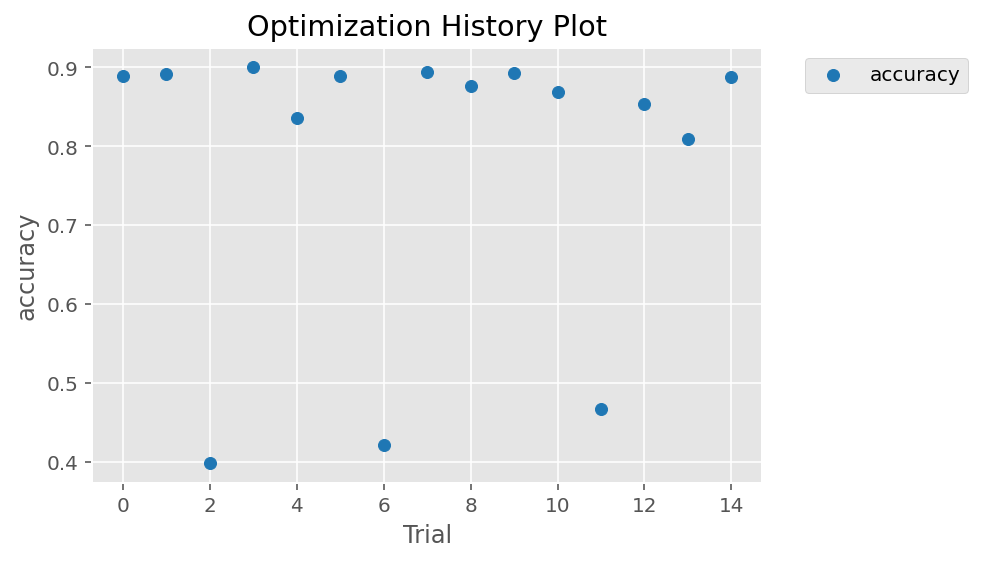

[W 2022-10-12 21:29:58,069] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


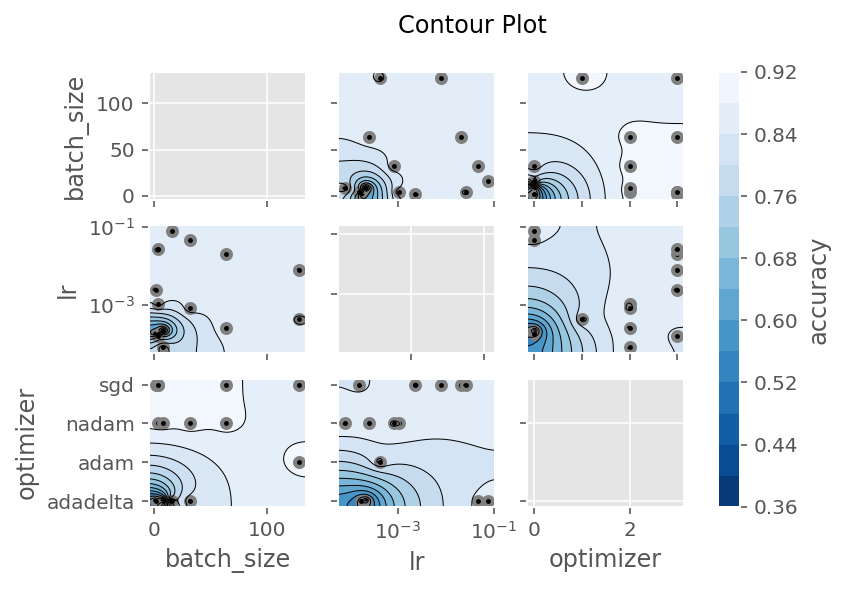

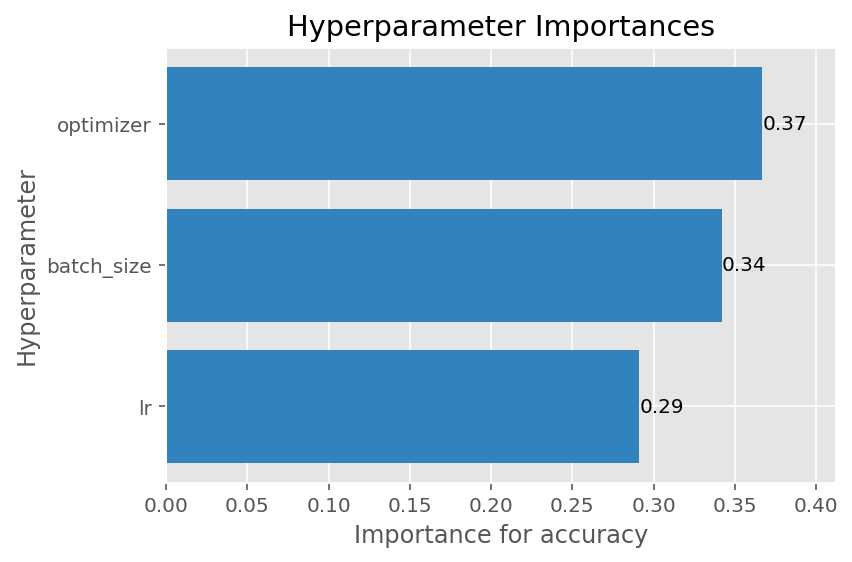

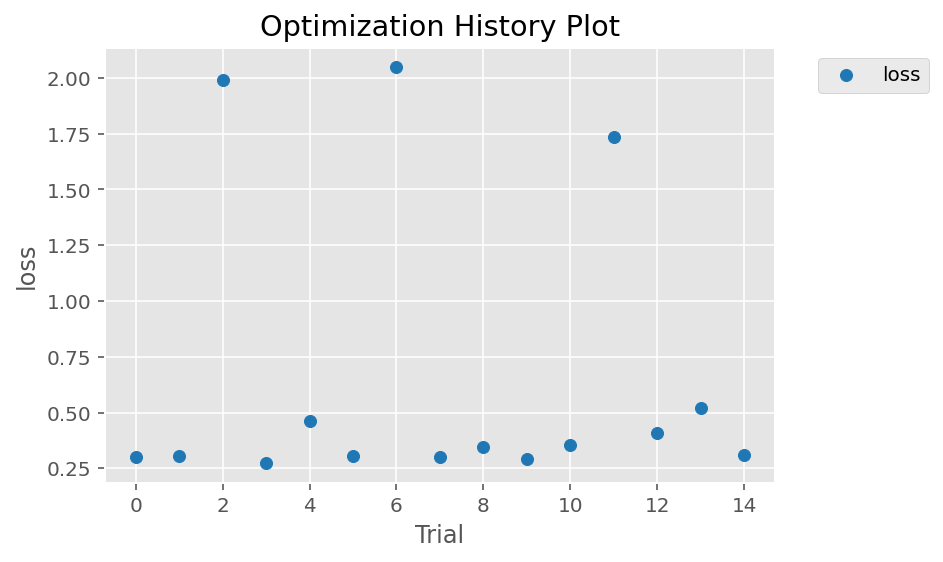

[W 2022-10-12 21:30:08,096] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


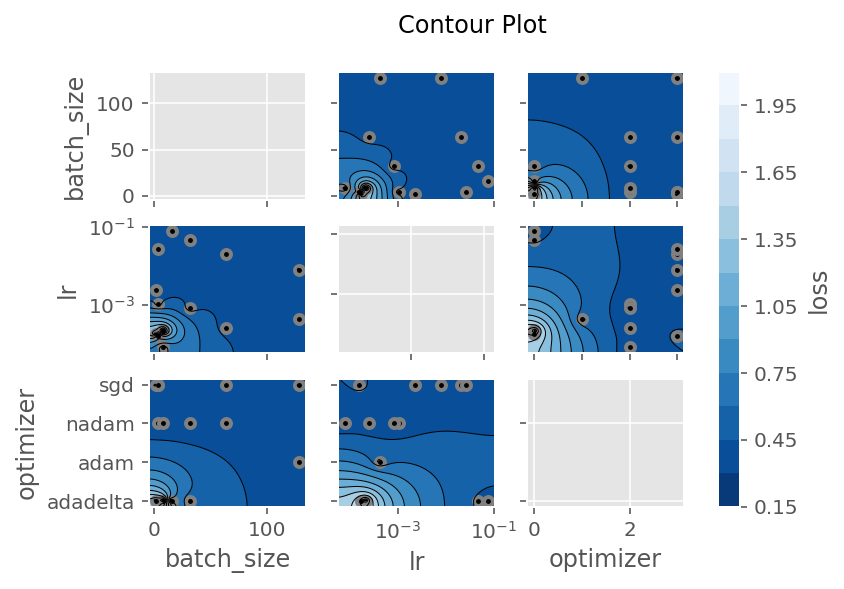

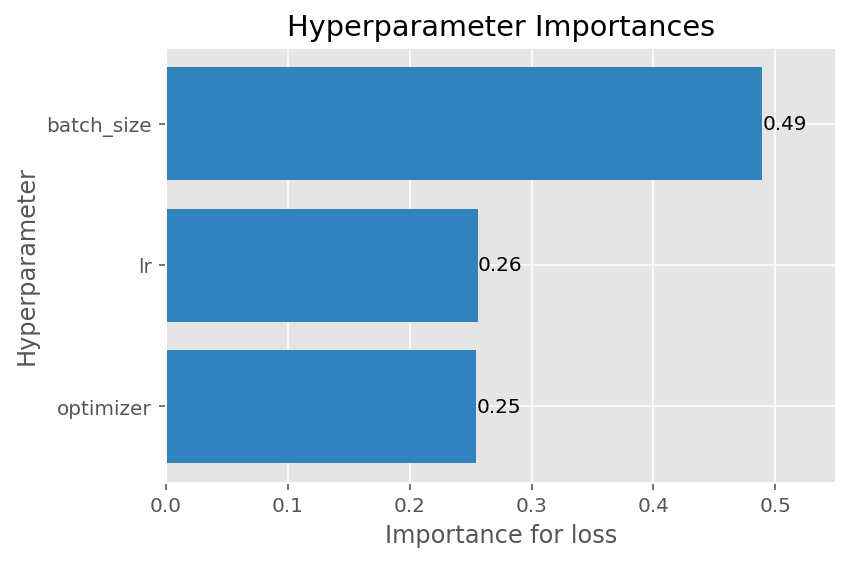

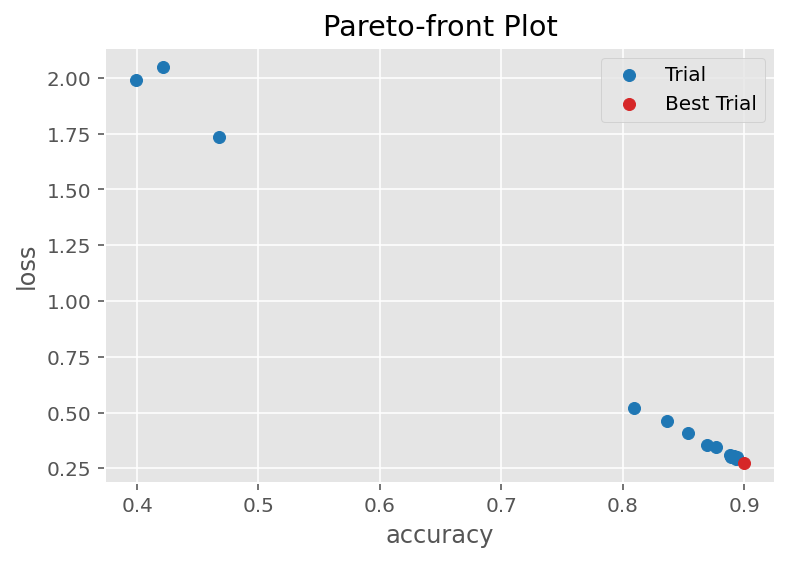

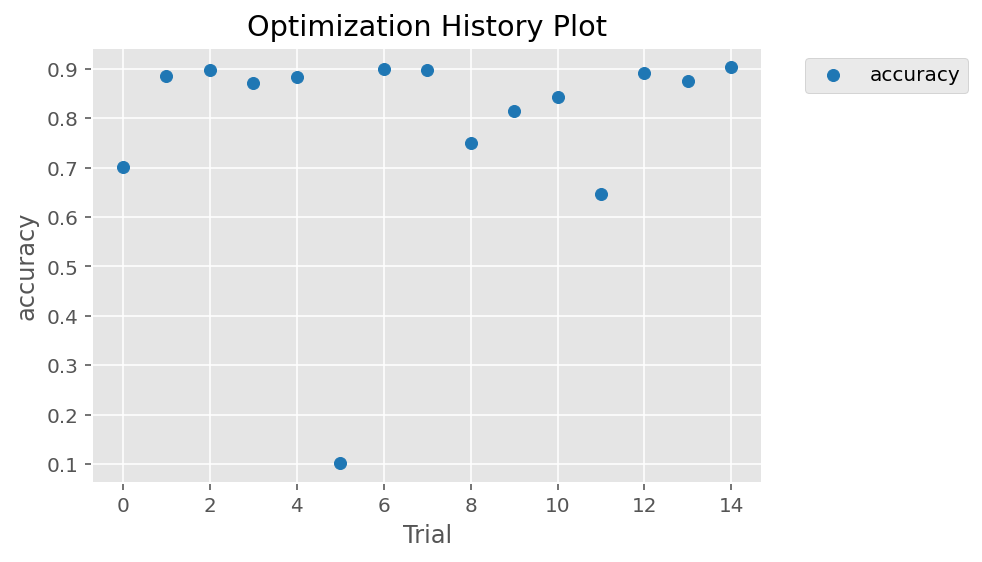

[W 2022-10-12 21:30:13,986] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


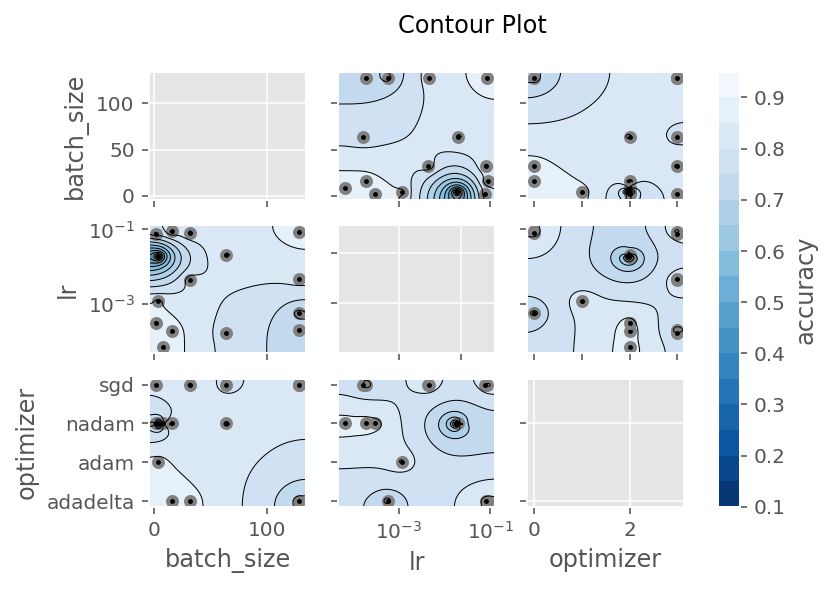

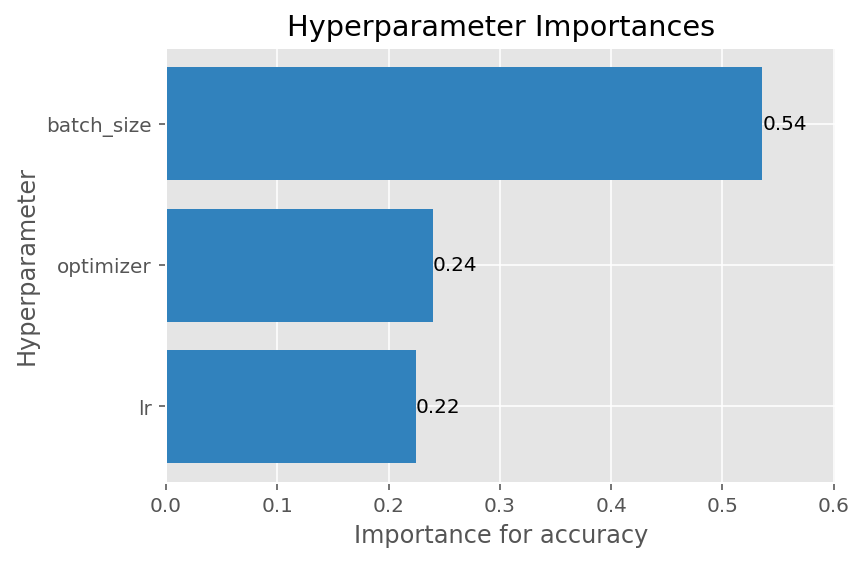

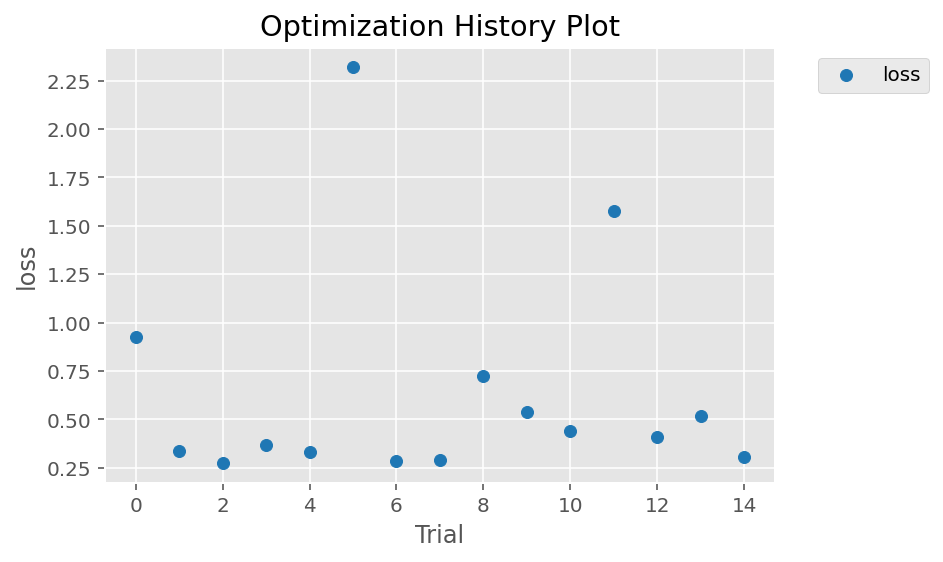

[W 2022-10-12 21:30:19,981] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


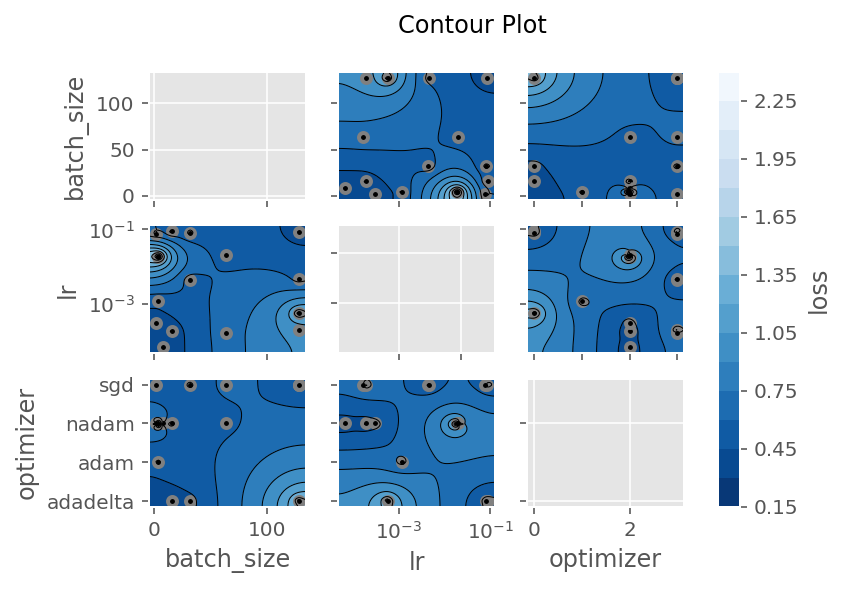

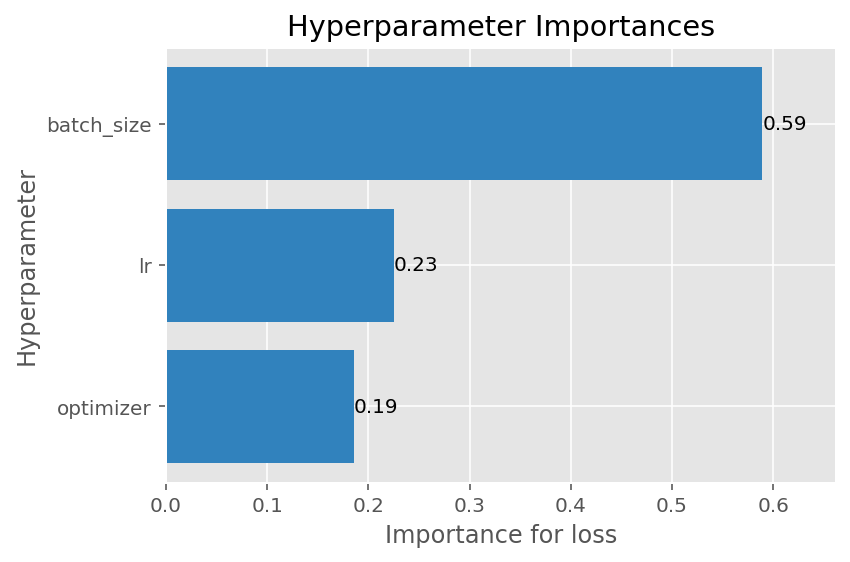

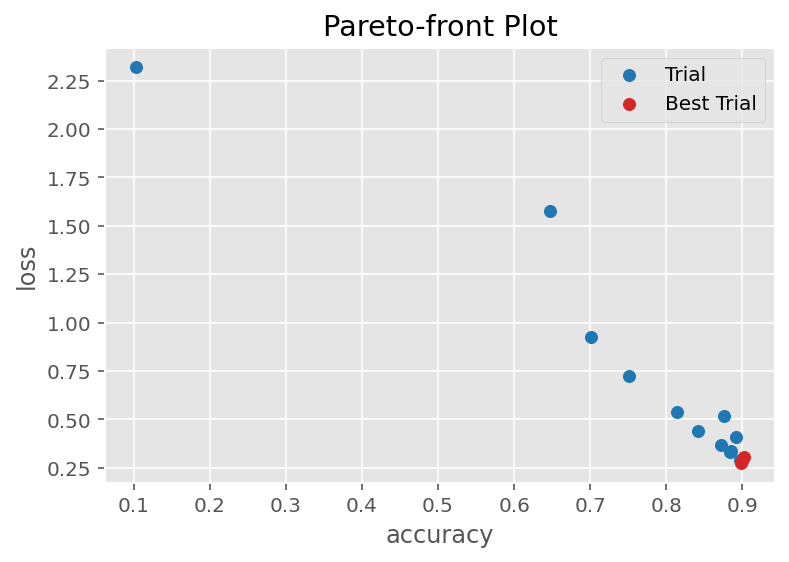

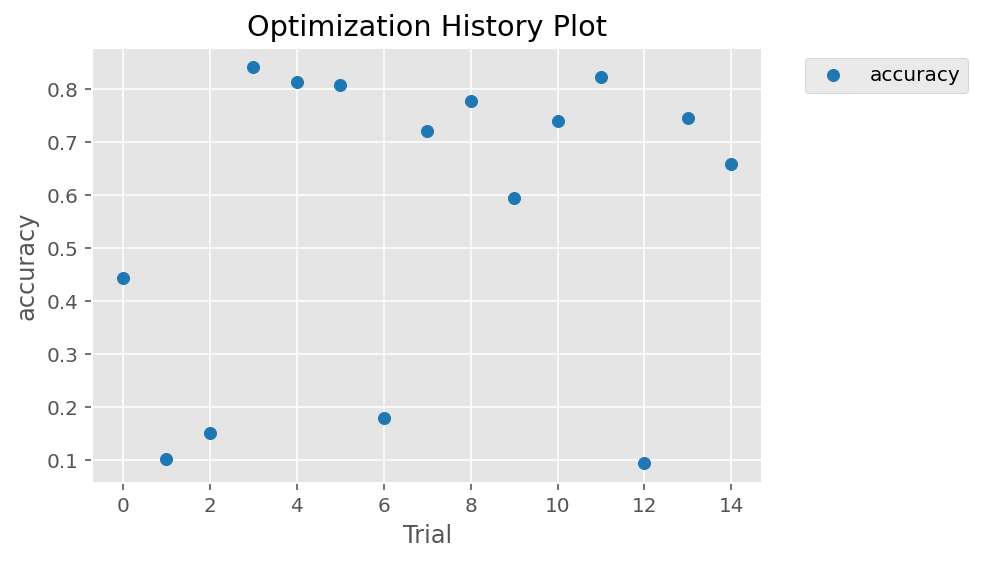

[W 2022-10-12 21:30:26,901] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


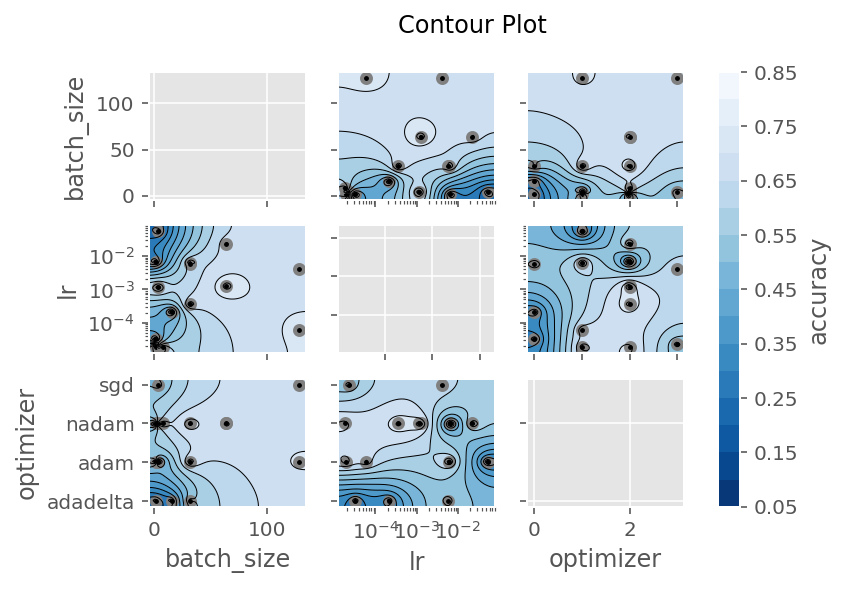

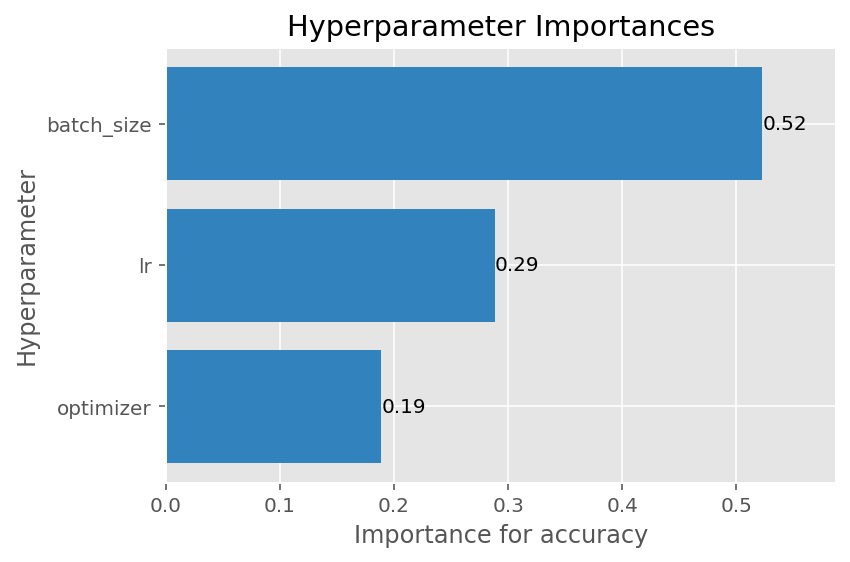

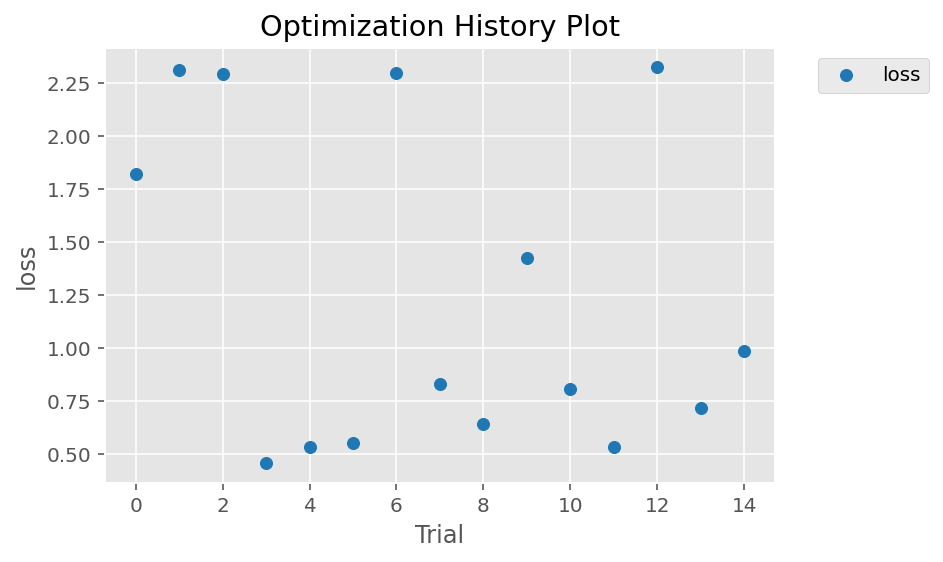

[W 2022-10-12 21:30:34,580] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


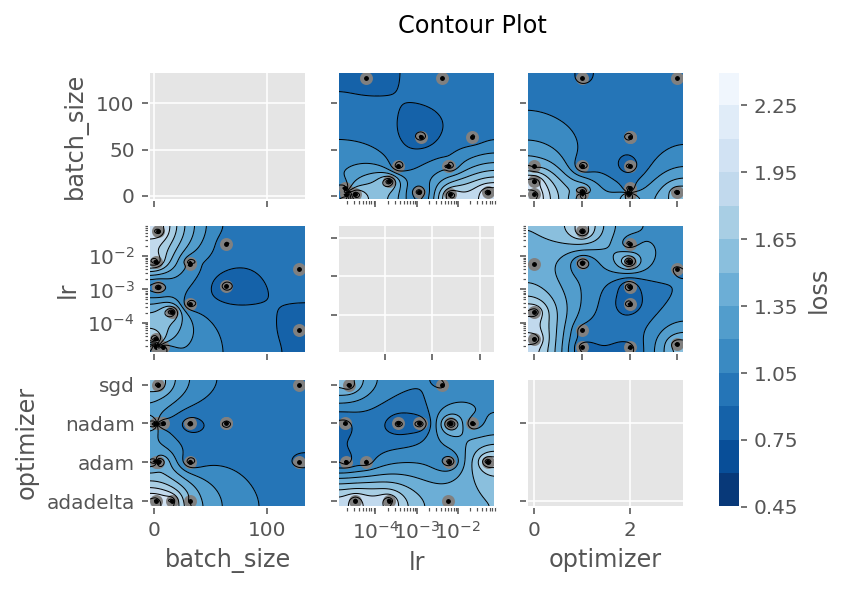

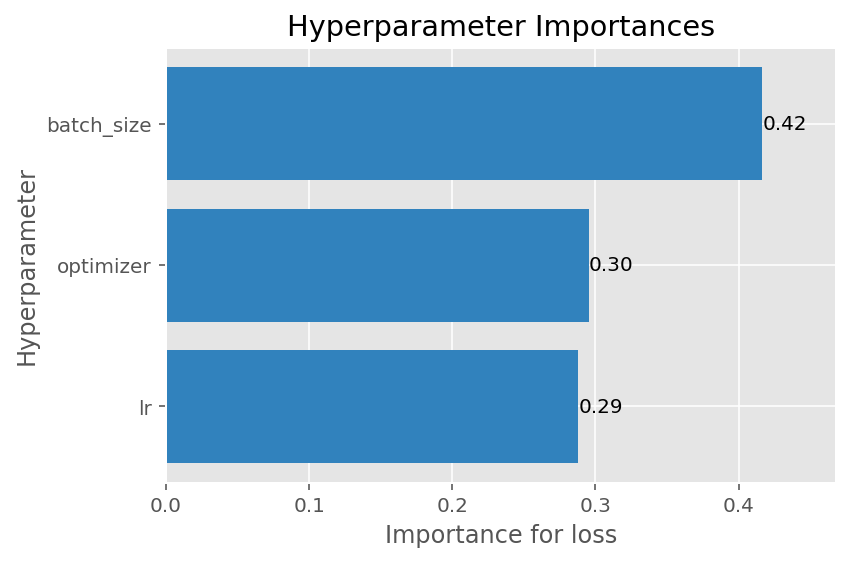

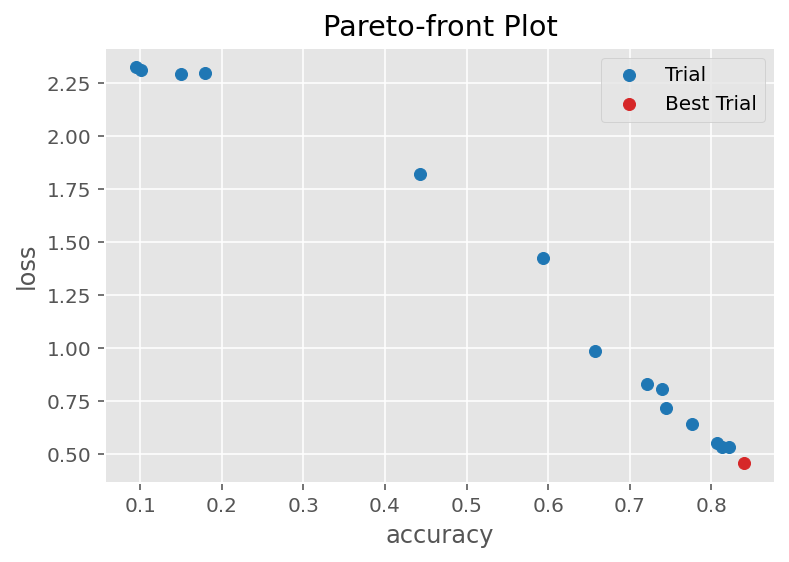

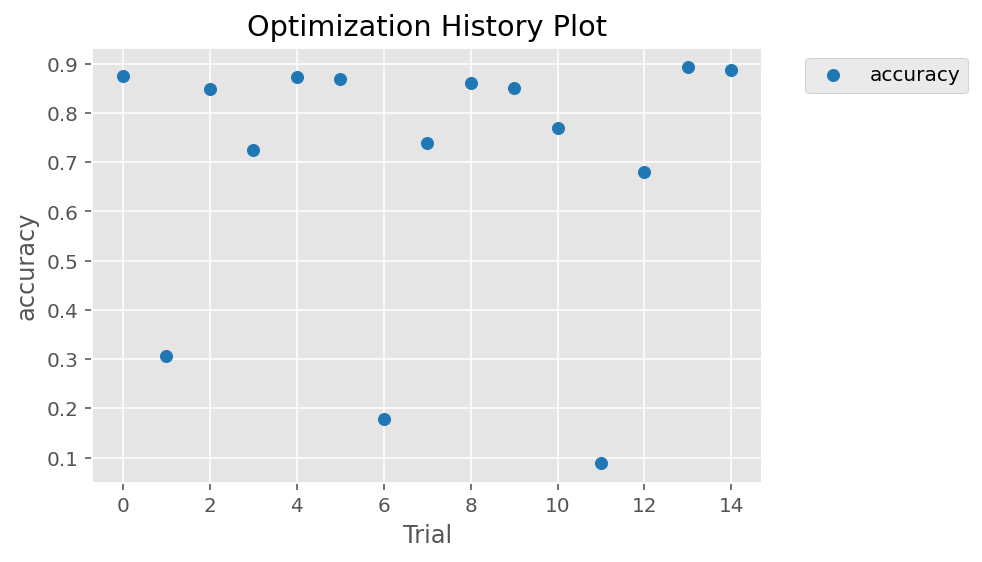

[W 2022-10-12 21:30:42,156] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


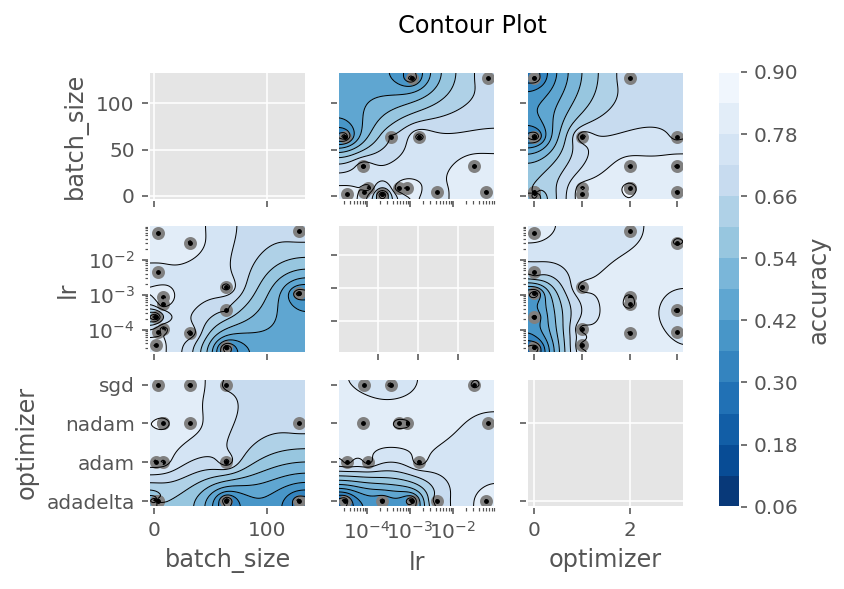

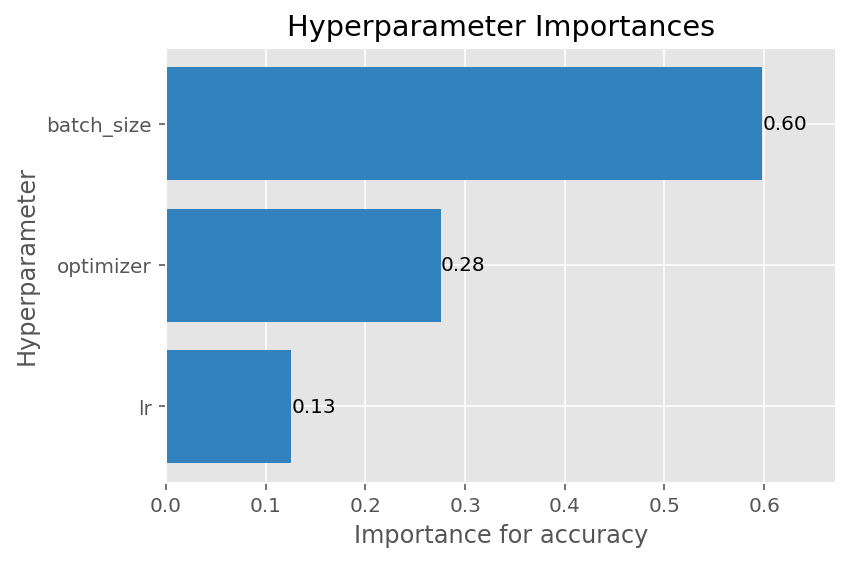

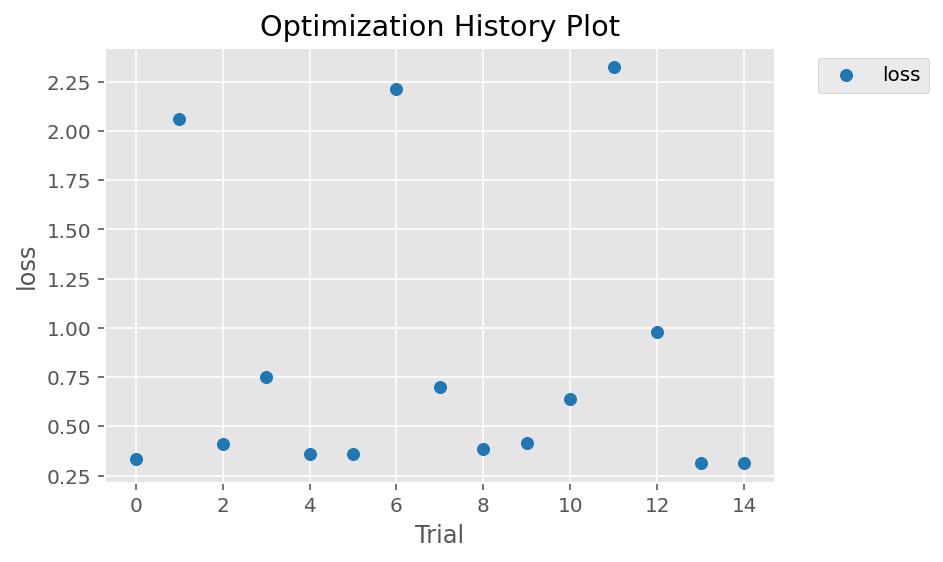

[W 2022-10-12 21:30:49,376] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


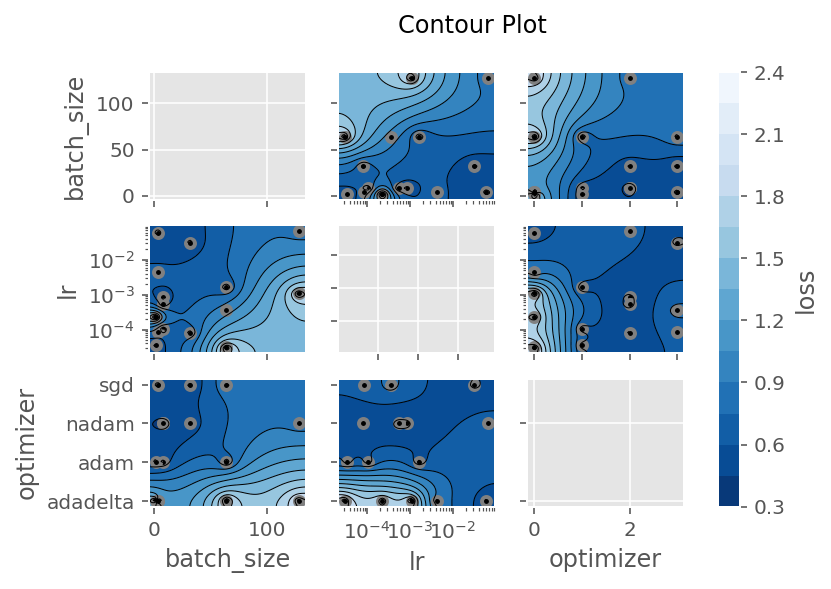

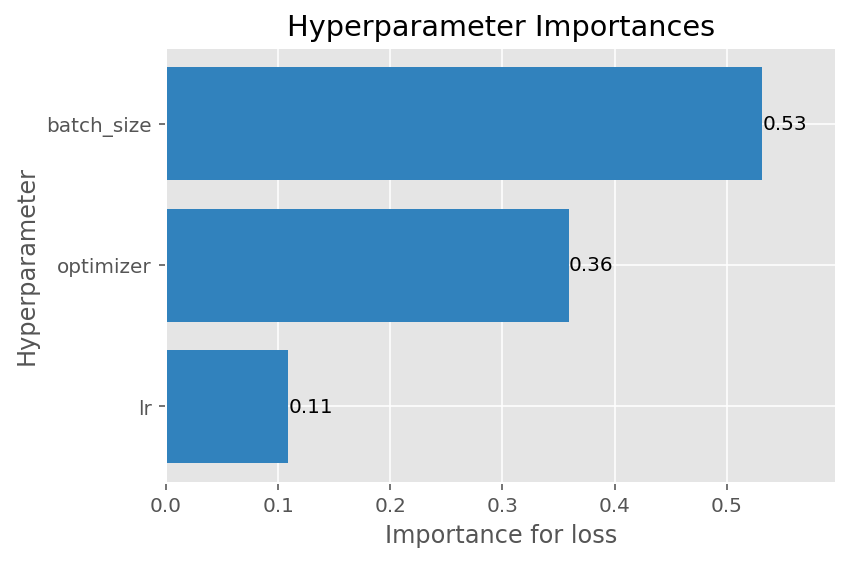

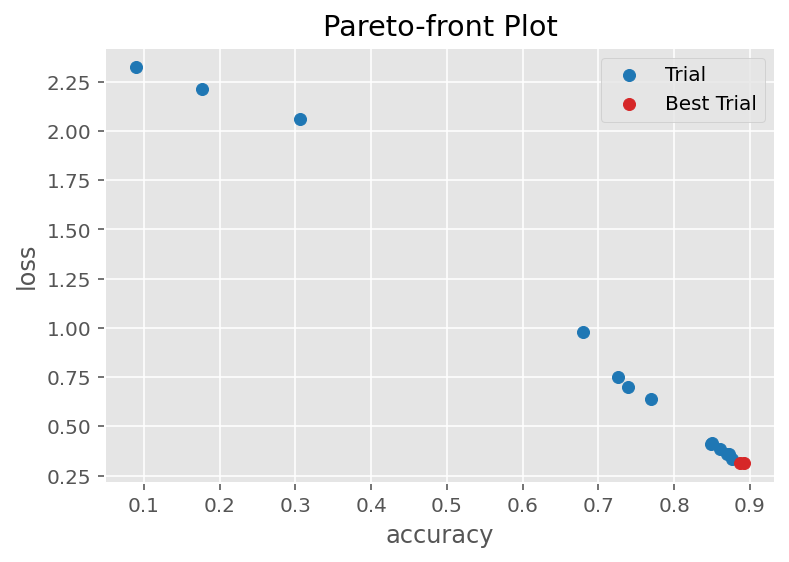

In [ ]:

##now for CNNS
studies = [] ##initialise studies
arch_type,n_architectures = 'CNN',4
run_studies(n_architectures,n_trials,arch_type,n_epochs)
df = results_as_df()
#saving dataframe to Google drive for later reference
df.to_csv(drive_path+"/CNN_Best_results.csv")
##storing outputs as plots in google drive
output_plots(name=arch_type)